In [ ]:
#!/usr/bin/env python

# ---- MODULE DOCSTRING

__doc__ = """
(C) Hive, Romain Wuilbercq, 2017
     _
    /_/_      .'''.
 =O(_)))) ...'     `.
    \_\              `.    .'''X
                       `..'
.---.  .---..-./`) ,---.  ,---.   .-''-.
|   |  |_ _|\ .-.')|   /  |   | .'_ _   \
|   |  ( ' )/ `-' \|  |   |  .'/ ( ` )   '
|   '-(_{;}_)`-'`"`|  | _ |  |. (_ o _)  |
|      (_,_) .---. |  _( )_  ||  (_,_)___|
| _ _--.   | |   | \ (_ o._) /'  \   .---.
|( ' ) |   | |   |  \ (_,_) /  \  `-'    /
(_{;}_)|   | |   |   \     /    \       /
'(_,_) '---' '---'    `---`      `'-..-'
The Artificial Bee Colony (ABC) algorithm is based on the
intelligent foraging behaviour of honey bee swarm, and was first proposed
by Karaboga in 2005.
Author:
------
Romain Wuilbercq
"""

# ---- IMPORT MODULES

import random
import sys
import copy


# ---- BEE CLASS

class Bee(object):
    """ Creates a bee object. """

    def __init__(self, lower, upper, fun, funcon=None):
        """
        Instantiates a bee object randomly.
        Parameters:
        ----------
            :param list lower  : lower bound of solution vector
            :param list upper  : upper bound of solution vector
            :param def  fun    : evaluation function
            :param def  funcon : constraints function, must return a boolean
        """

        # creates a random solution vector
        self._random(lower, upper)

        # checks if the problem constraint(s) are satisfied
        if not funcon:
            self.valid = True
        else:
            self.valid = funcon(self.vector)

        # computes fitness of solution vector
        if (fun != None):
            self.value = fun(self.vector)
        else:
            self.value = sys.float_info.max
        self._fitness()

        # initialises trial limit counter - i.e. abandonment counter
        self.counter = 0

    def _random(self, lower, upper):
        """ Initialises a solution vector randomly. """

        self.vector = []
        for i in range(len(lower)):
            self.vector.append( lower[i] + random.random() * (upper[i] - lower[i]) )

    def _fitness(self):
        """
        Evaluates the fitness of a solution vector.
        The fitness is a measure of the quality of a solution.
        """

        if (self.value >= 0):
            self.fitness = 1 / (1 + self.value)
        else:
            self.fitness = 1 + abs(self.value)

class BeeHive(object):
    """
    Creates an Artificial Bee Colony (ABC) algorithm.
    The population of the hive is composed of three distinct types
    of individuals:
        1. "employees",
        2. "onlookers",
        3. "scouts".
    The employed bees and onlooker bees exploit the nectar
    sources around the hive - i.e. exploitation phase - while the
    scouts explore the solution domain - i.e. exploration phase.
    The number of nectar sources around the hive is equal to
    the number of actively employed bees and the number of employees
    is equal to the number of onlooker bees.
    """

    def run(self):
        """ Runs an Artificial Bee Colony (ABC) algorithm. """

        cost = {};
        cost["best"] = [];
        cost["mean"] = []
        for itr in range(self.max_itrs):

            # employees phase
            for index in range(self.size):
                self.send_employee(index)

            # onlookers phase
            self.send_onlookers()

            # scouts phase
            self.send_scout()

            # computes best path
            self.find_best()

            # stores convergence information
            cost["best"].append( self.best )
            cost["mean"].append( sum( [ bee.value for bee in self.population ] ) / self.size )

            # prints out information about computation
            if self.verbose:
                self._verbose(itr, cost)

        return cost

    def __init__(self                 ,
                 lower, upper         ,
                 fun          = None  ,
                 numb_bees    =  30   ,
                 max_itrs     = 100   ,
                 max_trials   = None  ,
                 selfun       = None  ,
                 seed         = None  ,
                 verbose      = False ,
                 extra_params = None ,):
        """
        Instantiates a bee hive object.
        1. INITIALISATION PHASE.
        -----------------------
        The initial population of bees should cover the entire search space as
        much as possible by randomizing individuals within the search
        space constrained by the prescribed lower and upper bounds.
        Parameters:
        ----------
            :param list lower          : lower bound of solution vector
            :param list upper          : upper bound of solution vector
            :param def fun             : evaluation function of the optimal problem
            :param def numb_bees       : number of active bees within the hive
            :param int max_trials      : max number of trials without any improvment
            :param def selfun          : custom selection function
            :param int seed            : seed of random number generator
            :param boolean verbose     : makes computation verbose
            :param dict extra_params   : optional extra arguments for selection function selfun
        """

        # checks input
        assert (len(upper) == len(lower)), "'lower' and 'upper' must be a list of the same length."

        # generates a seed for the random number generator
        if (seed == None):
            self.seed = random.randint(0, 1000)
        else:
            self.seed = seed
        random.seed(self.seed)

        # computes the number of employees
        self.size = int((numb_bees + numb_bees % 2))

        # assigns properties of algorithm
        self.dim = len(lower)
        self.max_itrs = max_itrs
        if (max_trials == None):
            self.max_trials = 0.6 * self.size * self.dim
        else:
            self.max_trials = max_trials
        self.selfun = selfun
        self.extra_params = extra_params

        # assigns properties of the optimisation problem
        self.evaluate = fun
        self.lower    = lower
        self.upper    = upper

        # initialises current best and its a solution vector
        self.best = sys.float_info.max
        self.solution = None

        # creates a bee hive
        self.population = [ Bee(lower, upper, fun) for i in range(self.size) ]

        # initialises best solution vector to food nectar
        self.find_best()

        # computes selection probability
        self.compute_probability()

        # verbosity of computation
        self.verbose = verbose

    def find_best(self):
        """ Finds current best bee candidate. """

        values = [ bee.value for bee in self.population ]
        index  = values.index(min(values))
        if (values[index] < self.best):
            self.best     = values[index]
            self.solution = self.population[index].vector

    def compute_probability(self):
        """
        Computes the relative chance that a given solution vector is
        chosen by an onlooker bee after the Waggle dance ceremony when
        employed bees are back within the hive.
        """

        # retrieves fitness of bees within the hive
        values = [bee.fitness for bee in self.population]
        max_values = max(values)

        # computes probalities the way Karaboga does in his classic ABC implementation
        if (self.selfun == None):
            self.probas = [0.9 * v / max_values + 0.1 for v in values]
        else:
            if (self.extra_params != None):
                self.probas = self.selfun(list(values), **self.extra_params)
            else:
                self.probas = self.selfun(values)

        # returns intervals of probabilities
        return [sum(self.probas[:i+1]) for i in range(self.size)]

    def send_employee(self, index):
        """
        2. SEND EMPLOYED BEES PHASE.
        ---------------------------
        During this 2nd phase, new candidate solutions are produced for
        each employed bee by cross-over and mutation of the employees.
        If the modified vector of the mutant bee solution is better than
        that of the original bee, the new vector is assigned to the bee.
        """

        # deepcopies current bee solution vector
        zombee = copy.deepcopy(self.population[index])

        # draws a dimension to be crossed-over and mutated
        d = random.randint(0, self.dim-1)

        # selects another bee
        bee_ix = index;
        while (bee_ix == index): bee_ix = random.randint(0, self.size-1)

        # produces a mutant based on current bee and bee's friend
        zombee.vector[d] = self._mutate(d, index, bee_ix)

        # checks boundaries
        zombee.vector = self._check(zombee.vector, dim=d)

        # computes fitness of mutant
        zombee.value = self.evaluate(zombee.vector)
        zombee._fitness()

        # deterministic crowding
        if (zombee.fitness > self.population[index].fitness):
            self.population[index] = copy.deepcopy(zombee)
            self.population[index].counter = 0
        else:
            self.population[index].counter += 1

    def send_onlookers(self):
        """
        3. SEND ONLOOKERS PHASE.
        -----------------------
        We define as many onlooker bees as there are employed bees in
        the hive since onlooker bees will attempt to locally improve the
        solution path of the employed bee they have decided to follow
        after the waggle dance phase.
        If they improve it, they will communicate their findings to the bee
        they initially watched "waggle dancing".
        """

        # sends onlookers
        numb_onlookers = 0; beta = 0
        while (numb_onlookers < self.size):

            # draws a random number from U[0,1]
            phi = random.random()

            # increments roulette wheel parameter beta
            beta += phi * max(self.probas)
            beta %= max(self.probas)

            # selects a new onlooker based on waggle dance
            index = self.select(beta)

            # sends new onlooker
            self.send_employee(index)

            # increments number of onlookers
            numb_onlookers += 1

    def select(self, beta):
        """
        4. WAGGLE DANCE PHASE.
        ---------------------
        During this 4th phase, onlooker bees are recruited using a roulette
        wheel selection.
        This phase represents the "waggle dance" of honey bees (i.e. figure-
        eight dance). By performing this dance, successful foragers
        (i.e. "employed" bees) can share, with other members of the
        colony, information about the direction and distance to patches of
        flowers yielding nectar and pollen, to water sources, or to new
        nest-site locations.
        During the recruitment, the bee colony is re-sampled in order to mostly
        keep, within the hive, the solution vector of employed bees that have a
        good fitness as well as a small number of bees with lower fitnesses to
        enforce diversity.
        Parameter(s):
        ------------
            :param float beta : "roulette wheel selection" parameter - i.e. 0 <= beta <= max(probas)
        """

        # computes probability intervals "online" - i.e. re-computed after each onlooker
        probas = self.compute_probability()

        # selects a new potential "onlooker" bee
        for index in range(self.size):
            if (beta < probas[index]):
                return index

    def send_scout(self):
        """
        5. SEND SCOUT BEE PHASE.
        -----------------------
        Identifies bees whose abandonment counts exceed preset trials limit,
        abandons it and creates a new random bee to explore new random area
        of the domain space.
        In real life, after the depletion of a food nectar source, a bee moves
        on to other food sources.
        By this means, the employed bee which cannot improve their solution
        until the abandonment counter reaches the limit of trials becomes a
        scout bee. Therefore, scout bees in ABC algorithm prevent stagnation
        of employed bee population.
        Intuitively, this method provides an easy means to overcome any local
        optima within which a bee may have been trapped.
        """

        # retrieves the number of trials for all bees
        trials = [ self.population[i].counter for i in range(self.size) ]

        # identifies the bee with the greatest number of trials
        index = trials.index(max(trials))

        # checks if its number of trials exceeds the pre-set maximum number of trials
        if (trials[index] > self.max_trials):

            # creates a new scout bee randomly
            self.population[index] = Bee(self.lower, self.upper, self.evaluate)

            # sends scout bee to exploit its solution vector
            self.send_employee(index)

    def _mutate(self, dim, current_bee, other_bee):
        """
        Mutates a given solution vector - i.e. for continuous
        real-values.
        Parameters:
        ----------
            :param int dim         : vector's dimension to be mutated
            :param int current_bee : index of current bee
            :param int other_bee   : index of another bee to cross-over
        """

        return self.population[current_bee].vector[dim]    + \
               (random.random() - 0.5) * 2                 * \
               (self.population[current_bee].vector[dim] - self.population[other_bee].vector[dim])

    def _check(self, vector, dim=None):
        """
        Checks that a solution vector is contained within the
        pre-determined lower and upper bounds of the problem.
        """

        if (dim == None):
            range_ = range(self.dim)
        else:
            range_ = [dim]

        for i in range_:

            # checks lower bound
            if  (vector[i] < self.lower[i]):
                vector[i] = self.lower[i]

            # checks upper bound
            elif (vector[i] > self.upper[i]):
                vector[i] = self.upper[i]

        return vector

    def _verbose(self, itr, cost):
        """ Displays information about computation. """

        msg = "# Iter = {} | Best Evaluation Value = {} | Mean Evaluation Value = {} "
        print(msg.format(int(itr), cost["best"][itr], cost["mean"][itr]))

# ---- END

In [ ]:
#!/usr/bin/env python

# ---- MODULE DOCSTRING

__doc__ = """
(C) Hive, Romain Wuilbercq, 2017
     _
    /_/_      .'''.
 =O(_)))) ...'     `.
    \_\              `.    .'''X
                       `..'
.---.  .---..-./`) ,---.  ,---.   .-''-.
|   |  |_ _|\ .-.')|   /  |   | .'_ _   \
|   |  ( ' )/ `-' \|  |   |  .'/ ( ` )   '
|   '-(_{;}_)`-'`"`|  | _ |  |. (_ o _)  |
|      (_,_) .---. |  _( )_  ||  (_,_)___|
| _ _--.   | |   | \ (_ o._) /'  \   .---.
|( ' ) |   | |   |  \ (_,_) /  \  `-'    /
(_{;}_)|   | |   |   \     /    \       /
'(_,_) '---' '---'    `---`      `'-..-'
Description:
-----------
A series of utility functions (such as plotting function etc...).
"""

# ---- IMPORT MODULES

try:
    import matplotlib.pyplot as plt
    from matplotlib.font_manager import FontProperties
except:
    raise ImportError("Install 'matplotlib' to plot convergence results.")

# ---- CONVERGENCE PLOT

def ConvergencePlot(cost):
    """
    Monitors convergence.
    Parameters:
    ----------
        :param dict cost: mean and best cost over cycles/generations as returned
                          by an optimiser.
    """

    font = FontProperties();
    font.set_size('larger');
    labels = ["Best Cost Function", "Mean Cost Function"]
    plt.figure(figsize=(12.5, 4));
    plt.plot(range(len(cost["best"])), cost["best"], label=labels[0]);

    plt.xlabel("Iteration #");
    plt.ylabel("Value [-]");
    plt.legend(loc="best", prop = font);
    plt.xlim([0,len(cost["best"])]);
    plt.grid();
    plt.show();

# ---- END

In [ ]:
#!/usr/bin/env python

# ---- MODULE DOCSTRING

__doc__ = """
(C) Hive, Romain Wuilbercq, 2017
     _
    /_/_      .'''.
 =O(_)))) ...'     `.
    \_\              `.    .'''X
                       `..'
.---.  .---..-./`) ,---.  ,---.   .-''-.
|   |  |_ _|\ .-.')|   /  |   | .'_ _   \
|   |  ( ' )/ `-' \|  |   |  .'/ ( ` )   '
|   '-(_{;}_)`-'`"`|  | _ |  |. (_ o _)  |
|      (_,_) .---. |  _( )_  ||  (_,_)___|
| _ _--.   | |   | \ (_ o._) /'  \   .---.
|( ' ) |   | |   |  \ (_,_) /  \  `-'    /
(_{;}_)|   | |   |   \     /    \       /
'(_,_) '---' '---'    `---`      `'-..-'
The Artificial Bee Colony (ABC) algorithm is based on the
intelligent foraging behaviour of honey bee swarm, and was first proposed
by Karaboga in 2005.
"""

# ---- IMPORT MODULES

import math

try:
    import numpy as np
except:
    raise ImportError("Numpy module not installed.")

#import Hive
#import Utilities

def F2(x):
    temp1=0
    temp2=1
    for i in range(len(x)):
        temp1+=abs(x[i])
        temp2*=abs(x[i])
    return temp1+temp2

def F3(x):
    temp1=0
    for i in range(len(x)):
        temp2=0
        for j in range(i+1):
            temp2+=x[j]
        temp1+=temp2*temp2
    return temp1

def F11(x):

    temp1=0
    temp2=1
    for i in range(len(x)):
        temp1+=x[i]*x[i]
        temp2*=math.cos(x[i]/pow(i+1,0.5))

    return temp1/4000-temp2+1

def F12(x):
    temp1=0
    temp2=0
    for i in range(len(x)-1):
        temp1+=math.pow(y(x[i])-1,2)*(1+10*math.pow(math.sin(math.pi*y(x[i+1])),2))
    for j in range(len(x)):
        temp2+=u(x[j],10,100,4)
    temp1+=math.pi*1/len(x)*(10*math.pow(math.sin(math.pi*y(x[0])),2)+math.pow(y(x[len(x)-1])-1,2))

    return temp1+temp2
def y(x):
    return 1+(x+1)/4

def F13(x):
    temp1=0
    for i in range(len(x)-1):
        temp1+=math.pow(x[i]-1,2)*(1+math.pow(math.sin(3*math.pi*x[i+1]),2))
    temp1+=0.1*(math.pow(math.sin(3*math.pi*x[0]),2)+math.pow(x[len(x)-1]-1,2)*(1+math.pow(math.sin(2*math.pi*x[len(x)-1]),2)))
    temp2=0
    for j in range(len(x)):
        temp2+=u(x[j],5,100,4)

    return temp1+temp2

def u(x,a,k,m):
    if x>a:
        return k*math.pow(x-a,m)
    elif x<a*-1:
        return k*math.pow(-x-a,m)
    else:
        return 0

def F14(x):

    #table_a
    temp_a1=-32
    temp_a2=0
    a=[[0]*25 for i in range(2)]
    for j in range(25):
        a[0][j]=temp_a1
        temp_a1+=16
        if temp_a1>32:
            temp_a1=-32
    temp_a1=-32
    for j in range(25):
        a[1][j]=temp_a1
        temp_a2+=1
        if temp_a2==5:
            temp_a1+=16
            temp_a2=0

    temp1=0
    for j in range(25):
        temp2=0
        for i in range(len(x)):
            temp2+=math.pow(x[i]-a[i][j],6)
        temp1+=1/(j+temp2+1)
    return math.pow(1/500+temp1,-1)

def F15(x):
    #table_a and table_b
    a=[0.1957,0.1947,0.1735,0.16,0.0844,0.0627,0.0456,0.0342,0.0342,0.0235,0.0246]
    b=[4,2,1,1/2,1/4,1/6,1/8,1/10,1/12,1/14,1/16]

    temp1=0
    for i in range(11):
        temp2=x[0]*(b[i]*b[i]+b[i]*x[1])/(b[i]*b[i]+b[i]*x[2]+x[3])
        temp1+=math.pow(a[i]-temp2,2)
    return temp1

def evaluator(vector, a=1, b=100):
    """
    The Rosenbrock function is a non-convex function used as a performance test
    problem for optimization algorithms introduced by Howard H. Rosenbrock in
    1960. It is also known as Rosenbrock's valley or Rosenbrock's banana
    function.
    The function is defined by
                        f(x, y) = (a-x)^2 + b(y-x^2)^2
    It has a global minimum at (x, y) = (a, a**2), where f(x, y) = 0.
    """

    vector = np.array(vector)

    return (a - vector[0])**2 + b * (vector[1] - vector[0]**2)**2


# ---- SOLVE TEST CASE WITH ARTIFICIAL BEE COLONY ALGORITHM

'''
def run():

    # creates model
    ndim = int(4)
    model = BeeHive(lower     = [-5] *ndim ,
                         upper     = [5] *ndim ,
                         fun       = F15 ,
                         numb_bees =  50,
                         max_itrs  =  500,)

    # runs model
    cost = model.run()

    # plots convergence
    ConvergencePlot(cost)

    # prints out best solution
    #print('Best',cost["best"],'\n')
    #print('Mean',cost["mean"])

    print(cost)
    print("Fitness Value ABC: {0}".format(model.best))





if __name__ == "__main__":
    run()
'''

'\ndef run():\n\n    # creates model\n    ndim = int(4)\n    model = BeeHive(lower     = [-5] *ndim ,\n                         upper     = [5] *ndim ,\n                         fun       = F15 ,\n                         numb_bees =  50,\n                         max_itrs  =  500,)\n\n    # runs model\n    cost = model.run()\n\n    # plots convergence\n    ConvergencePlot(cost)\n\n    # prints out best solution\n    #print(\'Best\',cost["best"],\'\n\')\n    #print(\'Mean\',cost["mean"])\n    \n    print(cost)\n    print("Fitness Value ABC: {0}".format(model.best))\n\n\n\n\n\nif __name__ == "__main__":\n    run()\n'

##**Problem 1**

In [ ]:
import pandas as pd
import numpy as np

for i in range(50):
  ndim = int(30)
  model = BeeHive(lower     = [-50] *ndim ,
           upper     = [50] *ndim ,
           fun      = F12 ,
           numb_bees   =  50,
           max_itrs   =  2500,)
  # runs model
  cost = model.run()
  myframe = pd.DataFrame(cost)
  myframe = myframe.drop(['mean'], axis = 1)

  if i == 0:
  #best_avg = myframe['best'].mean()
    myframe_best = myframe
  elif i == 49:
    myframe_best = myframe_best + myframe
    myframe_best = myframe_best.div(50)
  else:
    myframe_best = myframe_best + myframe
myframe_best


,best
0,4.685158e+08
1,3.845018e+08
2,2.797897e+08
3,1.964963e+08
4,1.322583e+08
...,...
2495,4.609664e-16
2496,4.609664e-16
2497,4.609664e-16
2498,4.609664e-16


In [ ]:
import pandas as pd
import numpy as np

for i in range(50):
  ndim = int(30)
  model = BeeHive(lower     = [-100] *ndim ,
           upper     = [100] *ndim ,
           fun      = F3 ,
           numb_bees   =  50,
           max_itrs   =  2500,)
  # runs model
  cost = model.run()
  myframe = pd.DataFrame(cost)
  myframe = myframe.drop(['mean'], axis = 1)

  if i == 0:
  #best_avg = myframe['best'].mean()
    myframe_best = myframe
  elif i == 49:
    myframe_best = myframe_best + myframe
    myframe_best = myframe_best.div(50)
  else:
    myframe_best = myframe_best + myframe
myframe_best

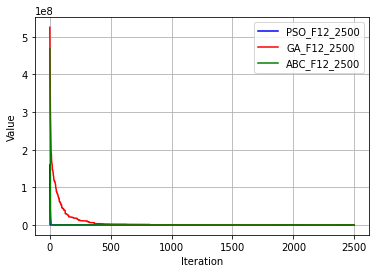

In [ ]:

#1
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import csv

PSO_F2_500=[

160116953.03173006,15174151.484241702,1796858.2766413765,53129.61504039306,899.9132116157721,92.17908753035043,47.14208896458147,25.837704362653383,14.738330370643148,10.123038175030382,7.265099309257708,5.959644066031218,5.437865719161017,5.096893971865771,5.048278593137254,5.009923752247154,5.00706318267959,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443,5.006904532258443


]
GA_F2_500 = [

525588764.6509041 ,
473298229.0484079 ,
429098399.0748098 ,
378972676.3485876 ,
325217518.11336017 ,
299267284.1697553 ,
279043817.5161068 ,
253177970.9899601 ,
233343469.0309329 ,
213803222.0681107 ,
205424648.2449035 ,
192710504.4539678 ,
190411362.15927067 ,
188503698.69184434 ,
172623706.94842726 ,
168903134.2897054 ,
166405090.38741863 ,
166171884.93866065 ,
162265621.90961093 ,
158313808.46840104 ,
158289650.1141527 ,
146947719.71630982 ,
146938833.27529195 ,
146938833.25994763 ,
144350252.32167697 ,
141821692.592529 ,
141321819.11045972 ,
141063154.8577193 ,
136006303.3921739 ,
132669032.35986198 ,
130653592.79694363 ,
128245147.22396553 ,
127699744.12167558 ,
119952524.07439387 ,
119066972.72876489 ,
118123980.53409767 ,
117676269.2061956 ,
117674904.21703461 ,
117674902.00325248 ,
115815831.23841229 ,
115751586.59117785 ,
114258247.7493708 ,
114258247.7493708 ,
112866687.3478084 ,
111288772.32292666 ,
110726198.29495747 ,
107702112.72073032 ,
107489622.9053111 ,
102662913.11823532 ,
98856472.66239414 ,
97008940.89023855 ,
96842172.28299744 ,
94803501.67385113 ,
94296879.893353 ,
88379966.42127475 ,
88379966.42127475 ,
88376064.68815066 ,
88376064.68815066 ,
86804064.38041365 ,
84610792.73179002 ,
84610790.90690614 ,
83898383.5052316 ,
82159682.76474167 ,
82159682.66370475 ,
82159682.55872032 ,
81647609.98325521 ,
79890135.571169 ,
76925704.4461601 ,
76307887.62236878 ,
74064001.27577335 ,
74056482.69334365 ,
74044375.50037679 ,
73983807.28398168 ,
72855492.94985987 ,
69906781.75826597 ,
69906781.16743013 ,
69906780.35804789 ,
69267145.58085038 ,
62616379.09540935 ,
62616379.09540935 ,
62553129.38427147 ,
62553129.35668992 ,
61226798.31374932 ,
61226798.25442151 ,
60275721.47786682 ,
59392067.31647659 ,
58433825.46417033 ,
58433825.19878189 ,
58366347.95055806 ,
57071526.864994414 ,
57071519.2415388 ,
54590704.28611092 ,
53622502.950158544 ,
53622502.950158544 ,
52855957.07056134 ,
52855954.53270511 ,
52855954.476982236 ,
52855954.46996541 ,
46670881.21980448 ,
46459371.23901418 ,
46459371.21094684 ,
45476123.101609096 ,
44543979.695258975 ,
44543979.19280372 ,
44543978.961251326 ,
44061474.70866906 ,
44023235.011394575 ,
43837861.36419982 ,
43837861.36059674 ,
43837857.981893905 ,
43726838.26127893 ,
43089573.29933042 ,
43089572.69155507 ,
43089572.55745311 ,
40791590.88827344 ,
39241711.781546056 ,
39241711.04008688 ,
38957561.1148445 ,
38957561.1148445 ,
38957560.9754498 ,
38957560.9754498 ,
38957559.69127702 ,
38957559.279498644 ,
38927381.50052424 ,
38767350.344090156 ,
38767350.29840822 ,
37104140.4992286 ,
30011457.092277236 ,
30011457.087420292 ,
30009625.481381007 ,
30009625.464587774 ,
29961828.835417263 ,
29959036.751209024 ,
29957812.25374996 ,
29098433.56563735 ,
29098433.038471248 ,
29098433.026331365 ,
28828091.157765444 ,
28828091.157765444 ,
28828091.140775837 ,
28828091.140775837 ,
28567144.535454202 ,
27871997.613240074 ,
27871997.5578267 ,
27101795.808550447 ,
27086819.124184735 ,
27086819.124184735 ,
27086818.838323146 ,
26944843.18952157 ,
26944842.87548472 ,
25930781.181031708 ,
24777460.26514364 ,
24670241.96479526 ,
24670241.399480484 ,
24670241.252804108 ,
24606157.943083774 ,
24604955.895194672 ,
21270508.31437493 ,
21249068.237583946 ,
21249068.237583946 ,
21234850.659379166 ,
20936549.17186506 ,
20936549.041196827 ,
20936548.908288404 ,
20936548.908288404 ,
20936548.871223237 ,
20936548.83976388 ,
20901975.406498507 ,
20901975.38690467 ,
20901975.3171952 ,
20899253.402447082 ,
20899253.043527883 ,
20899253.043527883 ,
20899253.01386718 ,
20849680.760984126 ,
20849679.5884585 ,
20743100.413742565 ,
20740876.070627015 ,
20740876.07046183 ,
20740875.930860195 ,
20740875.098724175 ,
20714719.35572261 ,
20394026.096070178 ,
20394025.710129652 ,
20394025.68490685 ,
19582989.732671067 ,
19582988.940573018 ,
19403885.119838323 ,
19403884.395345736 ,
19403884.395345736 ,
19403884.354844384 ,
19403884.354844384 ,
19403884.354844384 ,
19403884.354844384 ,
19403884.223713174 ,
19403884.223713174 ,
18583443.78615732 ,
18109092.108482618 ,
18109092.108482618 ,
18109092.058988743 ,
17952142.437940627 ,
17952142.398626525 ,
17952142.397846933 ,
17952142.29686563 ,
17952142.285366762 ,
17952142.11541472 ,
17894624.50128811 ,
17894624.49300261 ,
17894624.29955244 ,
17882114.12720367 ,
17882114.12720367 ,
17882114.057246834 ,
17882113.580452785 ,
17876232.910364877 ,
17802048.528115265 ,
17758925.314091142 ,
17758571.066182323 ,
17752431.994571704 ,
17378156.411048934 ,
17378156.41088682 ,
17362847.04270123 ,
17362847.04270123 ,
17362847.04270123 ,
17362847.04270123 ,
17362847.03059893 ,
15474854.563931966 ,
15474852.156508444 ,
15474852.156508444 ,
15474852.156508444 ,
15474852.156508444 ,
14755736.128982453 ,
13823086.940476535 ,
13823085.297439931 ,
13823085.297439931 ,
13823085.297439931 ,
13823085.297439931 ,
13823085.261849167 ,
13823085.126798954 ,
13823085.08979162 ,
13810451.208660742 ,
13810451.208660742 ,
12010878.250945462 ,
12010878.250541763 ,
12010878.250541763 ,
11801643.297128417 ,
11801642.487342807 ,
11799971.49332726 ,
11799970.580493674 ,
11799970.55348999 ,
11799942.873206686 ,
11799941.559234932 ,
11799941.210624844 ,
11799941.159448523 ,
11799941.159448523 ,
11753206.074273221 ,
11142829.595621545 ,
11068009.964484327 ,
11068009.964484327 ,
11068009.838884082 ,
11068009.838884082 ,
11068009.838884082 ,
11068009.81661307 ,
11068009.686253995 ,
11068007.779655863 ,
11068007.779655863 ,
10923064.41036281 ,
10923064.351449411 ,
10923064.351449411 ,
10923064.170575852 ,
10923064.136556253 ,
10923064.126050709 ,
10923064.09815352 ,
10923063.9471271 ,
10923063.944744892 ,
10923063.944744892 ,
10820018.506525211 ,
10820018.506525211 ,
10820018.506525211 ,
10820018.506525211 ,
10820018.336756647 ,
10820018.336756647 ,
10804488.278169991 ,
10804488.259240882 ,
10604074.669722203 ,
10604074.65682406 ,
10604072.766316416 ,
10604072.557181515 ,
10604072.557181515 ,
10604071.717538282 ,
10533596.042264622 ,
10533595.930797098 ,
10533595.526487995 ,
10533595.526487995 ,
10533595.526487995 ,
10533595.240213256 ,
10533595.240213256 ,
10533594.531536154 ,
10533594.510929272 ,
10533594.103165846 ,
10533594.100812346 ,
10533594.044734083 ,
10533593.942027297 ,
10533593.942027297 ,
10533593.65284568 ,
10533593.65284568 ,
10533593.65284568 ,
10532983.48859688 ,
8809344.852019954 ,
8809344.852019954 ,
8809344.816972941 ,
8808863.468926879 ,
8808863.468926879 ,
8808863.406351414 ,
8712407.737149296 ,
8712407.737149296 ,
8712407.737149296 ,
8712407.737149296 ,
8712407.737090254 ,
8712407.737090254 ,
7227736.877488022 ,
7227736.8734863615 ,
7227736.8734863615 ,
7227736.8734863615 ,
7227736.7890093485 ,
7227736.717739967 ,
7227736.712739401 ,
7227736.712739401 ,
7227736.712739401 ,
7227736.712739401 ,
6078995.994635311 ,
6078995.973174749 ,
6078995.973174749 ,
6078995.973174749 ,
6078995.763499251 ,
6078995.746057612 ,
6078995.565829205 ,
6078995.565829205 ,
6078995.565829205 ,
6078220.257907467 ,
6078220.086146972 ,
6078220.086146972 ,
6078220.086146972 ,
6078220.086110492 ,
6078219.976246015 ,
6078219.976246015 ,
6075647.606968277 ,
6075647.606968277 ,
6075647.605008171 ,
6075646.634810725 ,
6044483.161861037 ,
6044483.154174844 ,
6044483.154174844 ,
6044483.105738973 ,
6044483.1049703555 ,
6044483.085006843 ,
6044482.789549592 ,
6044482.6905404255 ,
5961791.976510999 ,
5961791.976374833 ,
5961791.976374833 ,
5961791.874615655 ,
5961791.338359054 ,
5961791.338359054 ,
5961791.250556397 ,
5961791.250556397 ,
5961791.241437465 ,
3466623.592521798 ,
3466623.592521798 ,
3466623.566568985 ,
3466623.566568985 ,
3466623.5547409668 ,
3466623.4228802146 ,
3466623.4227965567 ,
3381626.0263781836 ,
3381625.789474607 ,
3381625.789474607 ,
3381625.722971139 ,
3381625.722971139 ,
3381625.722971139 ,
3381625.71169537 ,
3378379.9300630745 ,
3378379.9300630745 ,
3378379.9297390003 ,
3378379.9266721727 ,
3378379.9266721727 ,
3378379.9266721727 ,
3378379.9107593624 ,
3378379.9107593624 ,
3378379.9107593624 ,
3378379.87251556 ,
3378379.492178254 ,
3306759.376725299 ,
3306759.3728608894 ,
3306759.3521214854 ,
3306759.169683589 ,
3306759.168930688 ,
3306756.7473190795 ,
3306756.7473190795 ,
3306756.278080354 ,
3306756.269520749 ,
3306756.269520749 ,
3306756.266985007 ,
3306756.197090371 ,
3306756.197090371 ,
3306756.197090371 ,
3306756.197090371 ,
3306756.1948628766 ,
3306756.1948628766 ,
3306755.9812849886 ,
3306755.9799244613 ,
3306755.8323253016 ,
3306755.800573656 ,
3306755.7371163317 ,
3306755.7371163317 ,
3306755.7371163317 ,
3306755.7371163317 ,
3306420.196564156 ,
3306420.196564156 ,
3306420.1958119287 ,
3306420.188590679 ,
3306420.187110106 ,
3306420.187110106 ,
3201736.7939201435 ,
3201736.7939201435 ,
2901351.034584192 ,
2901350.4378290423 ,
2901350.4378290423 ,
2901350.4378290423 ,
2901350.4378290423 ,
2901350.4378290423 ,
2901349.749247807 ,
2901349.435671736 ,
2901349.4192949026 ,
2901348.4538386436 ,
2901348.4538386436 ,
2901348.2857576283 ,
2901346.1273839613 ,
2901346.1271182327 ,
2901346.1271182327 ,
2901345.6984991515 ,
2901345.6984991515 ,
2506118.9918002496 ,
2506118.9851720245 ,
2506117.724350292 ,
2505239.226639785 ,
2505239.226639785 ,
2505239.226639785 ,
2505239.226639785 ,
2505239.2246702057 ,
2505239.2246702057 ,
2505239.2246702057 ,
2505239.2246702057 ,
2505239.189458644 ,
2505239.189370709 ,
2299668.66320434 ,
2299668.66320434 ,
2299668.644356219 ,
2299668.644356219 ,
2299668.643614304 ,
2299668.642694541 ,
2299668.5383978626 ,
2299668.5383978626 ,
2299668.5383978626 ,
2299668.5383978626 ,
2299668.522395701 ,
2299668.522395701 ,
2299668.5221441984 ,
2299668.5221441984 ,
2299668.5221441984 ,
2299668.520885211 ,
2299668.520885211 ,
2299668.520885211 ,
2299668.520885211 ,
2299668.520885211 ,
2299668.5061113806 ,
2299668.4406823097 ,
2299668.4352045767 ,
2299668.186074288 ,
2299668.186074288 ,
2299668.186074288 ,
2299668.1792472475 ,
2299668.176333356 ,
2299668.1617888752 ,
2299668.061464526 ,
2299668.044037768 ,
2299667.965153921 ,
2299667.9641095907 ,
2299667.927677941 ,
2299667.9257214135 ,
2299667.476232225 ,
2063416.1450574377 ,
2063415.8470091945 ,
2063415.5832800874 ,
2063415.3268617445 ,
2063415.3125208763 ,
2063415.3074891055 ,
2063415.3074891055 ,
2063414.3271507144 ,
2063413.4386182572 ,
2063413.4367748592 ,
2063413.394390124 ,
2063413.3931918629 ,
2063413.3931918629 ,
2063413.3863226282 ,
2063413.3863226282 ,
2063413.3863226282 ,
2061382.0827228345 ,
2061382.0825966664 ,
2061382.0825966664 ,
2061382.0825966664 ,
2061382.0097873998 ,
2061382.0097873998 ,
2061381.9668116004 ,
1989475.845096234 ,
1989475.3359148575 ,
1989475.0343916286 ,
1989474.9391986432 ,
1989473.6813193993 ,
1989473.6813193993 ,
1989473.6680970963 ,
1989473.6680970963 ,
1989473.6677435532 ,
1989473.662546854 ,
1989473.6501406091 ,
1989473.6501406091 ,
1989473.6501406091 ,
1989473.6501406091 ,
1989473.6497911478 ,
1989473.6497911478 ,
1989473.6497911478 ,
1989473.6497911478 ,
1989473.6497911478 ,
1989473.6305905357 ,
1989473.6293646633 ,
1989473.4611149842 ,
1989473.457698615 ,
1989473.4524829038 ,
1989473.4524829038 ,
1989473.4524829038 ,
1989473.4524829038 ,
1989473.4524829038 ,
1989473.4524829038 ,
1989473.4523066417 ,
1989473.4523066417 ,
1989473.427793117 ,
1989473.2237266977 ,
1989473.219788089 ,
1989473.219788089 ,
1989473.219788089 ,
1989473.2193798423 ,
1989473.2193798423 ,
1989473.2193798423 ,
1989473.2193798423 ,
1989473.2193798423 ,
1989473.2193798423 ,
1989473.2187064074 ,
1989473.206308177 ,
1989473.2061629498 ,
1989473.2061629498 ,
1989473.1947252476 ,
1989473.170032715 ,
1989473.170032715 ,
1989473.170032715 ,
1989473.170032715 ,
1989473.168757104 ,
1989472.998788524 ,
1989472.998788524 ,
1989472.9984780208 ,
1989472.9984780208 ,
1989472.9984780208 ,
1989472.9799081795 ,
1989472.9799081795 ,
1989472.9799081795 ,
1989472.9799081795 ,
1989472.9799081795 ,
1989472.9799081795 ,
1989472.9799081795 ,
1989472.979360585 ,
1989472.979360585 ,
1989472.9788579613 ,
1989472.9788579613 ,
1989472.9788579613 ,
1989472.9788579613 ,
1989472.9788579613 ,
1989472.9788579613 ,
1989472.9788579613 ,
1989472.9710506473 ,
1989472.9710506473 ,
1989472.9710506473 ,
1989472.9710506473 ,
1989472.9710506473 ,
1989472.9710506473 ,
1989472.9710506473 ,
1989472.9710506473 ,
1989472.9710506473 ,
1989472.9706736116 ,
1989472.9706736116 ,
1989472.9178133053 ,
1989472.9178133053 ,
1989472.9178133053 ,
1989472.9178133053 ,
1989472.9178133053 ,
1989472.3729905451 ,
1989472.3729173082 ,
1989472.3729173082 ,
1989472.3729173082 ,
1989472.3717335293 ,
1989472.3653581108 ,
1989472.3653381902 ,
1989472.3543362217 ,
1989472.3407908883 ,
1989472.3378766612 ,
1989472.3378766612 ,
1989472.3378766612 ,
1989472.335790808 ,
1989472.3353855014 ,
1989472.3353855014 ,
1989472.1548473563 ,
1989472.019333877 ,
1989472.0112419706 ,
1989471.9452124538 ,
1932829.876839656 ,
1932829.8745148475 ,
1932829.8738180473 ,
1932829.7999814884 ,
1932829.7237816632 ,
1932829.5774936615 ,
1932829.5774936615 ,
1892107.5784862633 ,
1828024.1328883076 ,
1828024.1328883076 ,
1828024.132846288 ,
1828024.132846288 ,
1450487.2505193453 ,
1450487.2505193453 ,
1450487.2505193453 ,
1450487.2504942634 ,
1450487.224172328 ,
1450487.224172328 ,
1450487.224172328 ,
1450487.224172328 ,
1450487.224172328 ,
1450487.224172328 ,
1450487.2235261714 ,
1450487.2045594184 ,
1450487.200916913 ,
1450487.200916913 ,
1450487.200916913 ,
1450487.200916913 ,
1450487.200916913 ,
1450487.185430316 ,
1450487.185430316 ,
1450487.185430316 ,
1450486.951630692 ,
1450486.8943916562 ,
1450486.8943916562 ,
1450486.8943916562 ,
1450486.8912264588 ,
1450486.8912264588 ,
1450486.8912264588 ,
1450486.8470742486 ,
1450486.846028579 ,
1450486.846028579 ,
1450486.846028579 ,
1450486.846028579 ,
1450486.8268825293 ,
1179377.4817326409 ,
1179377.4817326409 ,
1179377.464490324 ,
1179377.464490324 ,
1179377.4600928933 ,
1179377.2909146517 ,
1179377.2909144682 ,
1179377.2909144682 ,
1179377.0934114482 ,
1179377.0934114482 ,
1179377.087501102 ,
1179377.087501102 ,
1179377.0699612626 ,
1179377.0699612626 ,
1179377.0699612626 ,
1179377.0699612626 ,
1179377.069638215 ,
1179377.0695220514 ,
1179377.0695220514 ,
1179377.0695220514 ,
1179377.068211788 ,
1179377.0681682853 ,
1179377.0681682853 ,
1179377.0681682853 ,
1179377.0614519608 ,
1179377.0614519608 ,
1179377.0614519608 ,
1179377.0576776392 ,
1179377.0576776392 ,
1179377.0455790854 ,
1179377.0455790854 ,
1179377.0455790854 ,
1179377.0455790854 ,
1179377.0428427143 ,
1179377.0428427143 ,
1179377.0428427143 ,
1179377.0428427143 ,
1179377.0428427143 ,
1179377.0428427143 ,
1179377.0428427143 ,
1179377.0428427143 ,
1179377.0428427143 ,
1179377.0428427143 ,
1179377.0389501993 ,
1179377.0389501993 ,
1179377.0389501993 ,
1179377.0389501993 ,
1179377.0389501993 ,
1179377.0389501993 ,
1179377.0389501993 ,
1179377.0389501993 ,
1179377.0389501993 ,
1179377.0389501993 ,
1179377.0389501993 ,
1179376.9883531875 ,
1179376.9883531875 ,
1179376.9883531875 ,
1179376.988300787 ,
1179376.988300787 ,
1179376.988300787 ,
1179376.988300787 ,
1179376.9882051472 ,
1179376.9882051472 ,
1179376.9882051472 ,
1179376.981478414 ,
1179376.981478414 ,
1179376.7590117601 ,
1179376.7573734128 ,
1179376.7573734128 ,
1179376.7573734128 ,
1179376.7573734128 ,
1179376.7573734128 ,
1179376.7573734128 ,
1179376.7573734128 ,
1179376.5981669913 ,
1179376.5981669913 ,
1179376.5567657708 ,
1179376.5472345196 ,
1179376.5431144417 ,
1179007.7166336891 ,
1179007.7166336891 ,
1179007.5901277158 ,
1179007.5901277158 ,
1179007.5901277158 ,
1179007.5901277158 ,
1179007.5901277158 ,
1179007.587949268 ,
1179007.5865047358 ,
1179007.5865047358 ,
1179007.5865047358 ,
1179007.5865047358 ,
1179007.4400828255 ,
1179007.4400828255 ,
1179007.4400828255 ,
1179007.4400828255 ,
1179007.4400683357 ,
1179007.4400683357 ,
1179007.4139882894 ,
1179007.4139882894 ,
1179007.3108127548 ,
1179007.3108127548 ,
1179007.2748294598 ,
1179007.2748294598 ,
1179007.2748294598 ,
1179007.2748294598 ,
1179007.2748294598 ,
1179007.274044947 ,
1179007.274044947 ,
1179007.2717491454 ,
1179007.2717491454 ,
1179006.7605591132 ,
1179006.737772675 ,
1179006.7377681753 ,
1179006.7377681753 ,
1179006.7377681753 ,
1179006.737659141 ,
1179006.7374692785 ,
1179006.7374692785 ,
1179006.7374692785 ,
1179006.7374692785 ,
1179006.7374692785 ,
1179006.7374692785 ,
1179006.7374692785 ,
1179006.7374692785 ,
1179006.7286445606 ,
1179006.7040117602 ,
1121804.159268924 ,
1121804.159268924 ,
1121804.159268924 ,
1121804.159268924 ,
1121804.1001020917 ,
1121804.1001020917 ,
1121804.1001020917 ,
1121804.0994987076 ,
1121804.092648298 ,
1121804.092612562 ,
1121804.092612562 ,
1121804.089513719 ,
1121804.0875933638 ,
1121804.0875933638 ,
1121804.0875933638 ,
1121804.0751637972 ,
1121804.0732263348 ,
1121804.0732263348 ,
1121804.0732263348 ,
1121804.0732263348 ,
1121803.921327236 ,
1121803.921327236 ,
1121803.921327236 ,
1121803.921327236 ,
1121803.9014246329 ,
1121803.9014246329 ,
1121803.8972971963 ,
1121803.8972971963 ,
1121803.8913434623 ,
1121803.8839799135 ,
1121803.8839799135 ,
1121803.87143685 ,
227585.9889343448 ,
227585.9889343448 ,
227585.9889343448 ,
227585.96037905916 ,
227585.9603281262 ,
227585.9599543713 ,
227585.95733294488 ,
227585.47090721678 ,
227585.47044788138 ,
227584.70028260566 ,
227584.69336638929 ,
227584.69159996227 ,
227584.69159996227 ,
227584.69159996227 ,
227584.69159996227 ,
227584.69159996227 ,
227584.68936987533 ,
227584.6884998332 ,
227584.370135068 ,
227584.36761432726 ,
227584.36761432726 ,
227584.36761432726 ,
227584.36761432726 ,
227584.36761432726 ,
227584.36761432726 ,
227584.34914125598 ,
227584.34914125598 ,
227584.34914125598 ,
227584.34914125598 ,
227584.34573468656 ,
227584.34573468656 ,
227584.34573468656 ,
227584.34573468656 ,
227584.34573468656 ,
227584.34573468656 ,
227584.34573468656 ,
227584.34573468656 ,
227584.32670089114 ,
227584.3115485878 ,
227584.23435249273 ,
227584.23435249273 ,
227584.23435249273 ,
227584.23379820597 ,
227584.23368988276 ,
227584.23368988276 ,
227584.23368988276 ,
227584.19648725618 ,
227584.19648725618 ,
227584.19644756836 ,
227584.19644756836 ,
227584.19644756836 ,
227584.1953828776 ,
227584.193794126 ,
227584.193794126 ,
227584.06633707442 ,
227584.06633707442 ,
227584.06633707442 ,
227584.06633707442 ,
227584.06633707442 ,
227584.06319114708 ,
227584.06319114708 ,
227584.06319114708 ,
227584.06218723752 ,
227584.06218723752 ,
227584.05289287007 ,
227584.05289287007 ,
227584.05289287007 ,
227584.01354013867 ,
227584.00634798856 ,
227584.00634798856 ,
227584.00634798856 ,
227584.00634798856 ,
227584.00618992114 ,
227584.00618992114 ,
227584.00618992114 ,
227584.00618992114 ,
227584.00618992114 ,
227584.00618992114 ,
227584.00618992114 ,
227584.00618992114 ,
227584.00340352356 ,
227584.00340352356 ,
227584.00340352356 ,
227584.00340352356 ,
227583.98487510812 ,
227583.98487510812 ,
227583.98441378394 ,
227583.98441378394 ,
227583.97411951618 ,
227583.97411951618 ,
227583.97411951618 ,
227583.97411951618 ,
227583.97411951618 ,
227583.97411951618 ,
227583.97411951618 ,
227583.97411951618 ,
227583.97411951618 ,
227583.97411951618 ,
227583.97411951618 ,
227583.97411951618 ,
227583.97411951618 ,
227583.97411951618 ,
227583.97411951618 ,
227583.9713794766 ,
227583.96852889657 ,
227583.96852889657 ,
227583.96852889657 ,
227583.96852889657 ,
227583.96852889657 ,
227583.9684947652 ,
223349.7805688479 ,
223349.42843707476 ,
223349.42843707476 ,
223349.4271850875 ,
223349.4271850875 ,
223349.4271850875 ,
223349.4271850875 ,
223349.4271850875 ,
223349.39115731686 ,
223349.32727470627 ,
223349.3260696686 ,
223349.3260696686 ,
223349.3260696686 ,
223349.3260696686 ,
223349.3260696686 ,
223349.3260696686 ,
223349.3260696686 ,
223349.3260696686 ,
223349.3260696686 ,
223349.3260696686 ,
223349.3260696686 ,
223349.3260696686 ,
223349.3260696686 ,
223349.3260696686 ,
223349.3260696686 ,
223349.3260696686 ,
223349.3260696686 ,
223349.3260696686 ,
223349.3260696686 ,
223349.3260696686 ,
223349.3260696686 ,
223349.32394270707 ,
217528.5394063543 ,
217528.5394063543 ,
217528.53902523636 ,
217528.53902523636 ,
217528.53902523636 ,
217528.53902523636 ,
217528.53394604308 ,
217528.53394604308 ,
217528.53394604308 ,
217528.53394604308 ,
217528.5332971684 ,
217528.5332971684 ,
217528.5332971684 ,
217528.5332971684 ,
217528.53315733463 ,
217528.53315733463 ,
217528.53315733463 ,
217528.53315733463 ,
217528.22888673533 ,
217528.22888673533 ,
217528.22888673533 ,
217528.22888673533 ,
217528.227417437 ,
217528.227417437 ,
217528.22717188555 ,
217528.22717188555 ,
217528.22717188555 ,
217528.22717188555 ,
217528.22712436417 ,
217528.22712436417 ,
217527.29755350272 ,
217527.29754370108 ,
217527.29708540792 ,
217527.29708540792 ,
217527.2821320353 ,
217527.2821320353 ,
217527.2821320353 ,
217527.2821320353 ,
217527.2821320353 ,
217527.2821320353 ,
217527.2821320353 ,
217527.2821320353 ,
217527.2820622128 ,
217527.28123742857 ,
217527.28123742857 ,
217527.28123742857 ,
217527.28123137986 ,
217527.28123137986 ,
217527.28123137986 ,
217527.28123137986 ,
217527.28123137986 ,
217527.28123137986 ,
217527.28123137986 ,
217527.28123137986 ,
217527.00353544173 ,
217527.00353544173 ,
217527.00353544173 ,
217527.00353544173 ,
217527.0033631563 ,
217527.0033631563 ,
217527.0033631563 ,
217526.98695051938 ,
217526.98695051938 ,
217526.8805580686 ,
217526.83975236953 ,
2301.833569949266 ,
2301.833569949266 ,
2301.324172440727 ,
2301.324172440727 ,
2301.324172440727 ,
2301.324172440727 ,
2301.324172440727 ,
2301.324172440727 ,
2301.27551034218 ,
2301.27551034218 ,
2301.27551034218 ,
2301.27551034218 ,
2301.27551034218 ,
2301.27551034218 ,
2301.27551034218 ,
2301.27551034218 ,
2301.27551034218 ,
2301.2708039509766 ,
2301.2708039509766 ,
2301.2708039509766 ,
2301.1819302450986 ,
2301.1806652978626 ,
2301.0994992081746 ,
2301.0994992081746 ,
2301.0994992081746 ,
2301.0994992081746 ,
2301.0994992081746 ,
2301.0994992081746 ,
2300.873287515209 ,
2300.873287515209 ,
2300.873287515209 ,
2300.8710493215735 ,
2300.8683634892104 ,
2300.865965820643 ,
2300.8652545908967 ,
2300.8652545908967 ,
2300.864716701365 ,
2300.864716701365 ,
2300.864716701365 ,
2300.864716701365 ,
2300.864716701365 ,
2300.864303615749 ,
2300.8499921647162 ,
2300.8426815472817 ,
2300.8426815472817 ,
2300.8426815472817 ,
2300.8426815472817 ,
2300.84242933057 ,
2300.84242933057 ,
2300.84242933057 ,
2300.84242933057 ,
2300.842403543236 ,
2300.842403543236 ,
2300.8402636617416 ,
2300.8397582033153 ,
2300.8397582033153 ,
2300.8397582033153 ,
2300.8397582033153 ,
2300.8397582033153 ,
2300.8397582033153 ,
2300.8397582033153 ,
2300.8397582033153 ,
2300.8397582033153 ,
2300.8397582033153 ,
2300.8397582033153 ,
2300.8397582033153 ,
2300.8397582033153 ,
2300.8397582033153 ,
2300.8397582033153 ,
2300.8381559958134 ,
2300.8340509176237 ,
2300.8340509176237 ,
2300.8340509176237 ,
2300.8340509176237 ,
2300.8340509176237 ,
2300.8340509176237 ,
2300.8340509176237 ,
2300.8340509176237 ,
2300.8340509176237 ,
2300.8340509176237 ,
2300.8340509176237 ,
2300.8340509176237 ,
2300.8340509176237 ,
2300.8339815394424 ,
2300.8339815394424 ,
2300.8339815394424 ,
2300.831153905379 ,
2300.831148497329 ,
2300.822127094092 ,
2300.8208985758224 ,
2300.8208985758224 ,
2300.8208424102604 ,
2300.8179263466664 ,
2300.8179263466664 ,
2300.8179263466664 ,
2300.8179263466664 ,
2300.8179263466664 ,
2300.8179263466664 ,
2300.8179209386167 ,
2300.8179209386167 ,
2300.8179209386167 ,
2300.8179209386167 ,
2300.8179209386167 ,
2300.8179209386167 ,
2300.8179209386167 ,
2300.8179209386167 ,
2300.8179209386167 ,
2300.8179209386167 ,
2300.8179209386167 ,
2300.8179209386167 ,
2300.8179209386167 ,
2300.8179209386167 ,
2300.8179209386167 ,
2300.795451083325 ,
2300.72413594827 ,
2300.72413594827 ,
2300.72065094111 ,
2300.72065094111 ,
2300.7198620073236 ,
2300.7198620073236 ,
2300.7198620073236 ,
2300.7198620073236 ,
2300.7172300449465 ,
2300.7172300449465 ,
2300.7172300449465 ,
2300.7172300449465 ,
2300.7172300449465 ,
2300.7172300449465 ,
2300.7170818315894 ,
2300.7170762953383 ,
2300.7170762953383 ,
2300.7170762953383 ,
2300.716813776578 ,
2300.716813776578 ,
2300.6607523009575 ,
2300.6536524845874 ,
2300.6536524845874 ,
2300.6536524845874 ,
2300.6536524845874 ,
2300.6536524845874 ,
2300.6536524845874 ,
2300.6536524845874 ,
2300.6536524845874 ,
2300.648527205753 ,
2300.648527205753 ,
2300.648527205753 ,
3.349001254105408 ,
3.3213457648243434 ,
3.0695919353617986 ,
3.0695919353617986 ,
3.0695919353617986 ,
3.0695919353617986 ,
3.0695560144130223 ,
3.0695560144130223 ,
3.0210022780431185 ,
3.020552759917133 ,
3.020552759917133 ,
3.020552759917133 ,
3.0199738604503095 ,
3.019931575464279 ,
3.0197964722153627 ,
3.0197948482749566 ,
3.0197910616300185 ,
2.961776321910618 ,
2.9609234802908806 ,
2.95990744609203 ,
2.959166222426241 ,
2.959166222426241 ,
2.9556104145718423 ,
2.9440225541244147 ,
2.9440225541244147 ,
2.940775114759433 ,
2.9407404453424806 ,
2.9407404453424806 ,
2.9407404453424806 ,
2.9407404453424806 ,
2.9404884650805845 ,
2.9404884650805845 ,
2.9404884650805845 ,
2.9404884650805845 ,
2.9404884650805845 ,
2.91649356298586 ,
2.91649356298586 ,
2.8989113886726714 ,
2.8989113886726714 ,
2.8989113886726714 ,
2.8989113886726714 ,
2.89880833090549 ,
2.897246616760498 ,
2.897246616760498 ,
2.897246616760498 ,
2.889241562775809 ,
2.889241562775809 ,
2.8761842054689724 ,
2.8761842054689724 ,
2.8761842054689724 ,
2.8761842054689724 ,
2.8761842054689724 ,
2.8761842054689724 ,
2.8761842054689724 ,
2.6846932080416317 ,
2.2163453392905237 ,
2.2163453392905237 ,
2.2163453392905237 ,
2.206995047831025 ,
2.1838517201619583 ,
2.1838457211305005 ,
2.1838457211305005 ,
2.1838457211305005 ,
2.1838309489511962 ,
2.1838046591730587 ,
2.1838046591730587 ,
2.1838046591730587 ,
2.1838046591730587 ,
2.1838046591730587 ,
2.1667809436891967 ,
2.1667809436891967 ,
2.1667809436891967 ,
2.1667809436891967 ,
2.1667809436891967 ,
2.1667809436891967 ,
2.1667809436891967 ,
2.1667809436891967 ,
2.1667809436891967 ,
2.1667809436891967 ,
2.1667809436891967 ,
2.1667809436891967 ,
2.166565182348882 ,
2.166565182348882 ,
2.1664214011788294 ,
2.166393425592834 ,
2.166393425592834 ,
2.166376654867613 ,
2.166376654867613 ,
2.166376654867613 ,
2.166376654867613 ,
2.166376654867613 ,
2.166376654867613 ,
2.166376654867613 ,
2.166376654867613 ,
2.166376654867613 ,
2.166376654867613 ,
2.166376654867613 ,
2.097830617451362 ,
2.0973612695801465 ,
2.095302598195037 ,
2.095302598195037 ,
2.058798214495261 ,
2.058798214495261 ,
2.054057404570791 ,
2.042182254266281 ,
2.042182254266281 ,
2.042182254266281 ,
2.042182254266281 ,
2.042182254266281 ,
2.042182254266281 ,
1.9328033630887258 ,
1.9328033630887258 ,
1.9328033630887258 ,
1.9328033630887258 ,
1.931863787534748 ,
1.931863787534748 ,
1.931863787534748 ,
1.931863787534748 ,
1.931507883945518 ,
1.9171166152093346 ,
1.9171166152093346 ,
1.9166382881077448 ,
1.9166382881077448 ,
1.9155224675182112 ,
1.9155224675182112 ,
1.9155224675182112 ,
1.9155224675182112 ,
1.9155224675182112 ,
1.9155224675182112 ,
1.9155224675182112 ,
1.9155224675182112 ,
1.9154364330686127 ,
1.9154364330686127 ,
1.9154364330686127 ,
1.9154364330686127 ,
1.9154364330686127 ,
1.9154364330686127 ,
1.9154364330686127 ,
1.9154364330686127 ,
1.9154364330686127 ,
1.9154364330686127 ,
1.9154364330686127 ,
1.9154364330686127 ,
1.9154364330686127 ,
1.9154364330686127 ,
1.9154364330686127 ,
1.9154364330686127 ,
1.9154364330686127 ,
1.9154364330686127 ,
1.9154364330686127 ,
1.9154364330686127 ,
1.9154364330686127 ,
1.9154364330686127 ,
1.9154364330686127 ,
1.9154364330686127 ,
1.9154364330686127 ,
1.9118543369098193 ,
1.9118543369098193 ,
1.9118543369098193 ,
1.9118526408555976 ,
1.817465071417875 ,
1.8174491482399668 ,
1.8174491482399668 ,
1.8174491482399668 ,
1.7991824386995232 ,
1.7991824386995232 ,
1.7991824386995232 ,
1.6935520091251839 ,
1.6935520091251839 ,
1.6935520091251839 ,
1.6935520091251839 ,
1.6935520091251839 ,
1.6935520091251839 ,
1.6740493674419057 ,
1.6351289869981707 ,
1.6351289869981707 ,
1.2413385474292218 ,
1.2413385474292218 ,
1.233046980126504 ,
1.2242575868491425 ,
1.2219182724395077 ,
1.2219182724395077 ,
1.2117443733310942 ,
1.2117443733310942 ,
1.2117443733310942 ,
1.210966422683607 ,
1.210966422683607 ,
1.210966422683607 ,
1.2059312418901305 ,
1.203528894269295 ,
1.203528894269295 ,
1.1977932266455447 ,
1.1977932266455447 ,
1.1968044210949802 ,
1.1772668623823928 ,
1.1772668623823928 ,
1.1768064254089838 ,
1.172550597580141 ,
1.172550597580141 ,
1.172550597580141 ,
1.172550597580141 ,
1.172550597580141 ,
1.1725348282813615 ,
1.172533272064932 ,
1.172533272064932 ,
1.172533272064932 ,
1.172533272064932 ,
1.1720514824147044 ,
1.139151815621742 ,
1.1362622495231247 ,
1.1362622495231247 ,
1.1157768975901585 ,
1.1157768975901585 ,
1.1157768975901585 ,
1.1157768975901585 ,
1.1157505509353576 ,
1.1157505509353576 ,
1.1157505509353576 ,
1.1157505509353576 ,
1.1154796993720544 ,
1.093755104868628 ,
1.093755104868628 ,
1.093755104868628 ,
1.0928974434102912 ,
1.0928974434102912 ,
1.092868051773269 ,
1.092868051773269 ,
1.092868051773269 ,
1.0927948919182289 ,
1.0927948919182289 ,
1.0927948919182289 ,
1.0927948919182289 ,
1.0927948919182289 ,
1.0924359925642897 ,
1.0899147748923261 ,
1.078794604192869 ,
1.078794604192869 ,
1.078788624825916 ,
1.0786778398307089 ,
1.0786778398307089 ,
1.0786778398307089 ,
1.0786778398307089 ,
1.0786778398307089 ,
1.0786778398307089 ,
1.0786778398307089 ,
1.0786778398307089 ,
1.0786778398307089 ,
1.0786778398307089 ,
1.0786778398307089 ,
1.0786778398307089 ,
1.0786778398307089 ,
1.0786778398307089 ,
1.0786778398307089 ,
1.0786778398307089 ,
1.0786778398307089 ,
1.0786778398307089 ,
1.0786778398307089 ,
1.0786778398307089 ,
1.0786778398307089 ,
1.0775730321790422 ,
1.0775730321790422 ,
1.0775730321790422 ,
1.0775730321790422 ,
1.0775730321790422 ,
1.0775730321790422 ,
1.0775730321790422 ,
1.0775730321790422 ,
1.0775730321790422 ,
1.0775730321790422 ,
1.0775730321790422 ,
1.0775730321790422 ,
1.0775730321790422 ,
1.0775730321790422 ,
1.054109166755114 ,
1.054109166755114 ,
1.054109166755114 ,
1.054109166755114 ,
1.054109166755114 ,
1.054109166755114 ,
1.054109166755114 ,
1.054109166755114 ,
1.054109166755114 ,
1.054109166755114 ,
1.054109166755114 ,
1.054109166755114 ,
1.054109166755114 ,
1.054109166755114 ,
1.054109166755114 ,
1.054109166755114 ,
1.054109166755114 ,
1.053901884371712 ,
1.053901884371712 ,
1.053901884371712 ,
1.053901884371712 ,
1.0532289986070982 ,
1.0532289986070982 ,
1.0532289986070982 ,
1.0532289986070982 ,
0.9386422966810094 ,
0.9386422966810094 ,
0.9386422966810094 ,
0.9386422966810094 ,
0.9386422966810094 ,
0.9386422966810094 ,
0.9386422966810094 ,
0.9386422966810094 ,
0.9386422966810094 ,
0.9386422966810094 ,
0.9386422966810094 ,
0.9386422966810094 ,
0.9386422966810094 ,
0.930262706042542 ,
0.8957727905898712 ,
0.8957727905898712 ,
0.8957727905898712 ,
0.8957727905898712 ,
0.8957727905898712 ,
0.8957727905898712 ,
0.8957131979796434 ,
0.8957131979796434 ,
0.8957131979796434 ,
0.8956821765366098 ,
0.8956821765366098 ,
0.8648639441587246 ,
0.8648639441587246 ,
0.8618416520257325 ,
0.8618416520257325 ,
0.8600259895313914 ,
0.8600259895313914 ,
0.8600259895313914 ,
0.8600259895313914 ,
0.8600259895313914 ,
0.8600259895313914 ,
0.8600259895313914 ,
0.8600259895313914 ,
0.8600259895313914 ,
0.8600259895313914 ,
0.8600259895313914 ,
0.8397065649622971 ,
0.8397065649622971 ,
0.8397065649622971 ,
0.8397065649622971 ,
0.8396540785304006 ,
0.8396540785304006 ,
0.8396540785304006 ,
0.8396540785304006 ,
0.8395592917233127 ,
0.8235847228872885 ,
0.8235847228872885 ,
0.8235847228872885 ,
0.8235847228872885 ,
0.8224521115162818 ,
0.8224521115162818 ,
0.8224521115162818 ,
0.8224521115162818 ,
0.8224521115162818 ,
0.8224521115162818 ,
0.8224521115162818 ,
0.8224521115162818 ,
0.8221218977945569 ,
0.8221218977945569 ,
0.8221218977945569 ,
0.804028432123267 ,
0.8035568522919018 ,
0.8035568522919018 ,
0.8035568522919018 ,
0.8035568522919018 ,
0.8035568522919018 ,
0.8035568522919018 ,
0.7978835449601164 ,
0.7978835449601164 ,
0.7978835449601164 ,
0.7978835449601164 ,
0.797765483707317 ,
0.797765483707317 ,
0.737274559920268 ,
0.737274559920268 ,
0.7156841153632176 ,
0.7153934150216247 ,
0.7153934150216247 ,
0.7132915977788629 ,
0.7132915977788629 ,
0.7132915977788629 ,
0.7132915977788629 ,
0.7132915977788629 ,
0.7132915977788629 ,
0.7132915977788629 ,
0.7131595001862713 ,
0.7131595001862713 ,
0.7131595001862713 ,
0.7131358805027544 ,
0.7131358805027544 ,
0.7131358805027544 ,
0.7131358805027544 ,
0.7127824037633649 ,
0.7127737681313238 ,
0.7127737681313238 ,
0.7044424597414848 ,
0.7044424597414848 ,
0.7044424597414848 ,
0.7044424597414848 ,
0.7042620677889915 ,
0.7029796080500528 ,
0.7018789902087827 ,
0.7013354914461314 ,
0.7013354914461314 ,
0.7013354914461314 ,
0.7013354914461314 ,
0.7013354914461314 ,
0.7013354914461314 ,
0.7013354914461314 ,
0.7013354914461314 ,
0.7013354914461314 ,
0.7013354914461314 ,
0.7013354914461314 ,
0.7013354914461314 ,
0.7013354914461314 ,
0.7013354914461314 ,
0.7013354914461314 ,
0.7013354914461314 ,
0.7013354914461314 ,
0.7013354914461314 ,
0.7013354914461314 ,
0.7013354914461314 ,
0.7013354914461314 ,
0.7013354914461314 ,
0.7013354914461314 ,
0.7013354914461314 ,
0.6842607433959668 ,
0.6842607433959668 ,
0.6842607433959668 ,
0.6842607433959668 ,
0.6842607433959668 ,
0.6842607433959668 ,
0.6842607433959668 ,
0.6835101413092742 ,
0.6835101413092742 ,
0.6835101413092742 ,
0.6835101413092742 ,
0.6835101413092742 ,
0.6835101413092742 ,
0.6835101413092742 ,
0.6835101413092742 ,
0.6835101413092742 ,
0.6835101413092742 ,
0.6835101413092742 ,
0.6835101413092742 ,
0.6835101413092742 ,
0.6835101413092742 ,
0.6835101413092742 ,
0.6835101413092742 ,
0.6820783805849325 ,
0.6820783805849325 ,
0.6820783805849325 ,
0.6820783805849325 ,
0.6722386191632076 ,
0.6722386191632076 ,
0.6722386191632076 ,
0.6722386191632076 ,
0.6722386191632076 ,
0.6722386191632076 ,
0.6722386191632076 ,
0.6722386191632076 ,
0.6722386191632076 ,
0.6722386191632076 ,
0.6224650976357813 ,
0.6224650976357813 ,
0.6224650976357813 ,
0.6224650976357813 ,
0.6224650976357813 ,
0.6224650976357813 ,
0.6224650976357813 ,
0.6223014712215987 ,
0.6223014712215987 ,
0.6223014712215987 ,
0.6144146539656647 ,
0.6144146539656647 ,
0.6144146539656647 ,
0.6144146539656647 ,
0.6144146539656647 ,
0.6142829014628021 ,
0.6142829014628021 ,
0.6142829014628021 ,
0.6142829014628021 ,
0.6142829014628021 ,
0.6142829014628021 ,
0.6142829014628021 ,
0.6142829014628021 ,
0.6142829014628021 ,
0.6142829014628021 ,
0.6142829014628021 ,
0.6142829014628021 ,
0.6142704483703746 ,
0.6140533654868203 ,
0.6140533654868203 ,
0.6140533654868203 ,
0.6140533654868203 ,
0.6140533654868203 ,
0.6140498052539125 ,
0.6140498052539125 ,
0.6140181928655957 ,
0.6140181928655957 ,
0.6140181928655957 ,
0.6140181928655957 ,
0.6140181928655957 ,
0.6140181928655957 ,
0.6140181928655957 ,
0.6140181928655957 ,
0.6140181928655957 ,
0.6140181928655957 ,
0.6140181928655957 ,
0.6140181928655957 ,
0.6140181928655957 ,
0.6140181928655957 ,
0.6140181928655957 ,
0.6140181928655957 ,
0.6140181928655957 ,
0.6140181928655957 ,
0.6140181928655957 ,
0.6140181928655957 ,
0.6140181928655957 ,
0.6140181928655957 ,
0.6131358534296698 ,
0.6131358534296698 ,
0.6129162313251674 ,
0.6129162313251674 ,
0.6129162313251674 ,
0.6126628169574679 ,
0.6124698353641148 ,
0.6124698353641148 ,
0.6124698353641148 ,
0.6124698353641148 ,
0.6124698353641148 ,
0.6121118746373807 ,
0.6121118746373807 ,
0.6121118746373807 ,
0.6121118746373807 ,
0.6121118746373807 ,
0.6014512950558918 ,
0.6014512950558918 ,
0.6014512950558918 ,
0.6014512950558918 ,
0.6014202480894398 ,
0.5982612786370661 ,
0.5982612786370661 ,
0.5941787557295104 ,
0.5941787557295104 ,
0.5941676039422257 ,
0.5941676039422257 ,
0.5941676039422257 ,
0.5941676039422257 ,
0.5941676039422257 ,
0.5941676039422257 ,
0.5941676039422257 ,
0.5941676039422257 ,
0.5941676039422257 ,
0.594132485686709 ,
0.594132485686709 ,
0.594132485686709 ,
0.594132485686709 ,
0.594132485686709 ,
0.594132485686709 ,
0.594132485686709 ,
0.594132485686709 ,
0.594132485686709 ,
0.594132485686709 ,
0.594132485686709 ,
0.594132485686709 ,
0.594132485686709 ,
0.594132485686709 ,
0.594132485686709 ,
0.594132485686709 ,
0.5932543355141097 ,
0.5932543355141097 ,
0.5932543355141097 ,
0.5920817426601046 ,
0.5920283369044054 ,
0.5920283369044054 ,
0.5920283369044054 ,
0.5920283369044054 ,
0.5920283369044054 ,
0.5875560633492423 ,
0.5875560633492423 ,
0.5875560633492423 ,
0.5875560633492423 ,
0.5875560633492423 ,
0.5875560633492423 ,
0.5875560633492423 ,
0.585325892357106 ,
0.5569310834894752 ,
0.5568908289035174 ,
0.5568897735196812 ,
0.5568897735196812 ,
0.5568897735196812 ,
0.5568897735196812 ,
0.5568897735196812 ,
0.5418550119797468 ,
0.5418270248511693 ,
0.5418270248511693 ,
0.5418270248511693 ,
0.5418270248511693 ,
0.5418270248511693 ,
0.5418270248511693 ,
0.5418270248511693 ,
0.5418270248511693 ,
0.5418270248511693 ,
0.5418270248511693 ,
0.5418270248511693 ,
0.5418270248511693 ,
0.5418270248511693 ,
0.5418270248511693 ,
0.5418270248511693 ,
0.5418270248511693 ,
0.5418270248511693 ,
0.5418270248511693 ,
0.5418270248511693 ,
0.5418270248511693 ,
0.5418238114312497 ,
0.5418238114312497 ,
0.5418238114312497 ,
0.5418238114312497 ,
0.5418238114312497 ,
0.5418238114312497 ,
0.5232654553629629 ,
0.5226441057647568 ,
0.5226441057647568 ,
0.5226441057647568 ,
0.5226441057647568 ,
0.5226441057647568 ,
0.5226441057647568 ,
0.5226441057647568 ,
0.5226441057647568 ,
0.5226441057647568 ,
0.5226441057647568 ,
0.5226441057647568 ,
0.5226441057647568 ,
0.5226441057647568 ,
0.5226441057647568 ,
0.5226441057647568 ,
0.5226441057647568 ,
0.5226441057647568 ,
0.5226441057647568 ,
0.5226441057647568 ,
0.5226441057647568 ,
0.4956148368691122 ,
0.4956148368691122 ,
0.4956148368691122 ,
0.4956148368691122 ,
0.4956148368691122 ,
0.4956148368691122 ,
0.4956148368691122 ,
0.4956148368691122 ,
0.4956148368691122 ,
0.4956148368691122 ,
0.4956148368691122 ,
0.4955399437805534 ,
0.4955399437805534 ,
0.4955399437805534 ,
0.4955399437805534 ,
0.4955399437805534 ,
0.4955399437805534 ,
0.4955399437805534 ,
0.4955380356961559 ,
0.4954166574551198 ,
0.4954166574551198 ,
0.49263072503592586 ,
0.4879279986167136 ,
0.48790172821745814 ,
0.4873866570966068 ,
0.4873866570966068 ,
0.4873866570966068 ,
0.4873866570966068 ,
0.4873866570966068 ,
0.4873866570966068 ,
0.4873866570966068 ,
0.4872087269901814 ,
0.4872087269901814 ,
0.4872087269901814 ,
0.4872087269901814 ,
0.4872087269901814 ,
0.48547321715941305 ,
0.48543351930988315 ,
0.48448111555589884 ,
0.48402525312940997 ,
0.48402525312940997 ,
0.48402525312940997 ,
0.48402525312940997 ,
0.4723212025135167 ,
0.46737880852256536 ,
0.46737880852256536 ,
0.46698070385259033 ,
0.46698070385259033 ,
0.46697309863804304 ,
0.4668813827504346 ,
0.4668813827504346 ,
0.4668813827504346 ,
0.4668813827504346 ,
0.4668813827504346 ,
0.4668813827504346 ,
0.4668813827504346 ,
0.46686794659749536 ,
0.46686794659749536 ,
0.46686794659749536 ,
0.46686794659749536 ,
0.46686794659749536 ,
0.46686794659749536 ,
0.46686794659749536 ,
0.46686794659749536 ,
0.4658839569258541 ,
0.4658839569258541 ,
0.4658839569258541 ,
0.4658839569258541 ,
0.46582851131308667 ,
0.46582851131308667 ,
0.46582851131308667 ,
0.46582851131308667 ,
0.46582851131308667 ,
0.46582851131308667 ,
0.46582851131308667 ,
0.46551617272257345 ,
0.46260234627193725 ,
0.46228821248116964 ,
0.46212660218478213 ,
0.46211346980080664 ,
0.46211346980080664 ,
0.4618710543562253 ,
0.4618710543562253 ,
0.4618710543562253 ,
0.45989451794549197 ,
0.4598942807437361 ,
0.4598942807437361 ,
0.4598942807437361 ,
0.4598942807437361 ,
0.4598942807437361 ,
0.45989425438493964 ,
0.45786300530131835 ,
0.45786300530131835 ,
0.45786300530131835 ,
0.457860674982713 ,
0.457860674982713 ,
0.45766998342173676 ,
0.45766998342173676 ,
0.45766998342173676 ,
0.45766998342173676 ,
0.45766998342173676 ,
0.45766998342173676 ,
0.45766998342173676 ,
0.45766998342173676 ,
0.45766998342173676 ,
0.45766998342173676 ,
0.45766998342173676 ,
0.45766998342173676 ,
0.45766998342173676 ,
0.45766998342173676 ,
0.45766998342173676 ,
0.45766998342173676 ,
0.45766998342173676 ,
0.45766998342173676 ,
0.45766998342173676 ,
0.45766998342173676 ,
0.45766998342173676 ,
0.45766998342173676 ,
0.45765879767315654 ,
0.45765879767315654 ,
0.45765879767315654 ,
0.45765879767315654 ,
0.45765879767315654 ,
0.45765879767315654 ,
0.4576480149993202 ,
0.4575645518651286 ,
0.4575645518651286 ,
0.4575645518651286 ,
0.4575645518651286 ,
0.4575645518651286 ,
0.4575645518651286 ,
0.4575645518651286 ,
0.4575645518651286 ,
0.4575645518651286 ,
0.4575645518651286 ,
0.4575645518651286 ,
0.4575645518651286 ,
0.4575645518651286 ,
0.4575645518651286 ,
0.4575645518651286 ,
0.4575645518651286 ,
0.4575645518651286 ,
0.4575645518651286 ,
0.4575645518651286 ,
0.4575645518651286 ,
0.4575645518651286 ,
0.4575645518651286 ,
0.4575645518651286 ,
0.4575645518651286 ,
0.4575645518651286 ,
0.4575645518651286 ,
0.4575645518651286 ,
0.4562000748397297 ,
0.4552081758868912 ,
0.4508055553975382 ,
0.4508055553975382 ,
0.45069909394129765 ,
0.45042250911332066 ,
0.45042250911332066 ,
0.45042250911332066 ,
0.45042250911332066 ,
0.45042250911332066 ,
0.45042250911332066 ,
0.45042250911332066 ,
0.45042250911332066 ,
0.45042250911332066 ,
0.45042250911332066 ,
0.45042250911332066 ,
0.45042250911332066 ,
0.45042250911332066 ,
0.45042250911332066 ,
0.45042250911332066 ,
0.45042250911332066 ,
0.45042250911332066 ,
0.45042250911332066 ,
0.4503917737691374 ,
0.45036897187404856 ,
0.45036897187404856 ,
0.45036897187404856 ,
0.45036897187404856 ,
0.45036897187404856 ,
0.45036897187404856 ,
0.45036897187404856 ,
0.4152640688699271 ,
0.4148131600363095 ,
0.4148131600363095 ,
0.41435122684169334 ,
0.41435122684169334 ,
0.41435122684169334 ,
0.41435122684169334 ,
0.4142598361249459 ,
0.4142598361249459 ,
0.4142598361249459 ,
0.4142598361249459 ,
0.4142598361249459 ,
0.4142598361249459 ,
0.4142598361249459 ,
0.4142598361249459 ,
0.4142598361249459 ,
0.4142598361249459 ,
0.4142598361249459 ,
0.4142598361249459 ,
0.4142598361249459 ,
0.4142598361249459 ,
0.4142598361249459 ,
0.4142598361249459 ,
0.4142598361249459 ,
0.4142598361249459 ,
0.41415097445970367 ,
0.41415097445970367 ,
0.41415097445970367 ,
0.41415097445970367 ,
0.41415097445970367 ,
0.41415097445970367 ,
0.4141075936508304 ,
0.4139939667937446 ,
0.41396958329167355 ,
0.41396958329167355 ,
0.41396958329167355 ,
0.41396958329167355 ,
0.41396958329167355 ,
0.41396958329167355 ,
0.41396958329167355 ,
0.41396958329167355 ,
0.41396958329167355 ,
0.41396958329167355 ,
0.41396958329167355 ,
0.41396958329167355 ,
0.4139166014066738 ,
0.4139166014066738 ,
0.4139166014066738 ,
0.4139166014066738 ,
0.4139166014066738 ,
0.4139166014066738 ,
0.4139166014066738 ,
0.4139141076373841 ,
0.4139141076373841 ,
0.4139141076373841 ,
0.4139141076373841 ,
0.4139020749465858 ,
0.4138498854037282 ,
0.4135780475433813 ,
0.4135780475433813 ,
0.4135780475433813 ,
0.4126791619559183 ,
0.41267512770306586 ,
0.4126663741376523 ,
0.4126663741376523 ,
0.4126663741376523 ,
0.4126663741376523 ,
0.4126663741376523 ,
0.41266138404207353 ,
0.41266138404207353 ,
0.41266138404207353 ,
0.41266138404207353 ,
0.41266138404207353 ,
0.41266138404207353 ,
0.41266138404207353 ,
0.41266138404207353 ,
0.41254287780393745 ,
0.41254287780393745 ,
0.41254287780393745 ,
0.41254287780393745 ,
0.41254287780393745 ,
0.41254287780393745 ,
0.41254287780393745 ,
0.41254287780393745 ,
0.40248884147294917 ,
0.40231083192033723 ,
0.40231083192033723 ,
0.40231083192033723 ,
0.40231083192033723 ,
0.40231083192033723 ,
0.40231083192033723 ,
0.40231083192033723 ,
0.40231083192033723 ,
0.40231083192033723 ,
0.40231083192033723 ,
0.40231083192033723 ,
0.40231083192033723 ,
0.40231083192033723 ,
0.40231083192033723 ,
0.40231083192033723 ,
0.40231083192033723 ,
0.40229189024316947 ,
0.40229189024316947 ,
0.40229189024316947 ,
0.40229189024316947 ,
0.40229189024316947 ,
0.40229189024316947 ,
0.40228737867118797 ,
0.40228737867118797 ,
0.40228737867118797 ,
0.40228737867118797 ,
0.40228737867118797 ,
0.40228737867118797 ,
0.40228737867118797 ,
0.40228737867118797 ,
0.4021299929220857 ,
0.4021299929220857 ,
0.4021299929220857 ,
0.4021299929220857 ,
0.40116548350493797 ,
0.40116548350493797 ,
0.40116548350493797 ,
0.4011553458521027 ,
0.4011553458521027 ,
0.4011553458521027 ,
0.40069595247539586 ,
0.40069595247539586 ,
0.40069595247539586 ,
0.40069595247539586 ,
0.40069595247539586 ,
0.40069595247539586 ,
0.40069595247539586 ,
0.40069595247539586 ,
0.40069595247539586 ,
0.3962331213434475 ,
0.3961798007728384 ,
0.3961798007728384 ,
0.3961798007728384 ,
0.3961798007728384 ,
0.3961798007728384 ,
0.3961798007728384 ,
0.3961798007728384 ,
0.3961798007728384 ,
0.3961798007728384 ,
0.3957669304705772 ,
0.3957669304705772 ,
0.3957669304705772 ,
0.3957669304705772 ,
0.3957464101318583 ,
0.3957464101318583 ,
0.3957464101318583 ,
0.3957464101318583 ,
0.3957464101318583 ,
0.3957464101318583 ,
0.3957464101318583 ,
0.3957464101318583 ,
0.3957464101318583 ,
0.3957464101318583 ,
0.3957464101318583 ,
0.3957464101318583 ,
0.3923680369694916 ,
0.3923680369694916 ,
0.3921472368892306 ,
0.39204061124350065 ,
0.39204061124350065 ,
0.39204061124350065 ,
0.39204061124350065 ,
0.39195158000032004 ,
0.39195158000032004 ,
0.39195158000032004 ,
0.39195158000032004 ,
0.391855736563501 ,
0.391855736563501 ,
0.39160689882318916 ,
0.39160689882318916 ,
0.39160689882318916 ,
0.39160689882318916 ,
0.39160689882318916 ,
0.39160689882318916 ,
0.39077026283781596 ,
0.39077026283781596 ,
0.39077026283781596 ,
0.39077026283781596 ,
0.39077026283781596 ,
0.39077026283781596 ,
0.39077026283781596 ,
0.39077026283781596 ,
0.39077026283781596 ,
0.39077026283781596 ,
0.3893662653399395 ,
0.3893662653399395 ,
0.3893662653399395 ,
0.3893662653399395 ,
0.38930304527659715 ,
0.38930304527659715 ,
0.38930304527659715 ,
0.38868372026824877 ,
0.38868372026824877 ,
0.3828883127640465 ,
0.3828883127640465 ,
0.3828883127640465 ,
0.3828883127640465 ,
0.382843212826952 ,
0.382843212826952 ,
0.382843212826952 ,
0.382843212826952 ,
0.382843212826952 ,
0.3820530718886987 ,
0.3819297629523696 ,
0.3819297629523696 ,
0.38190476692869857 ,
0.38190476692869857 ,
0.38190476692869857 ,
0.38190476692869857 ,
0.38190476692869857 ,
0.38190476692869857 ,
0.38190476692869857 ,
0.38190476692869857 ,
0.38190476692869857 ,
0.38190476692869857 ,
0.38190476692869857 ,
0.38190476692869857 ,
0.32489371836198044 ,
0.32489371836198044 ,
0.32489371836198044 ,
0.32435063135238495 ,
0.3241162455389841 ,
0.3241162455389841 ,
0.3241162455389841 ,
0.3241162455389841 ,
0.3237541875325872 ,
0.3237541875325872 ,
0.3237541875325872 ,
0.32279688069158674 ,
0.32277425240411106 ,
0.32277425240411106 ,
0.32277425240411106 ,
0.32276293826037317 ,
0.32276293826037317 ,
0.32276293826037317 ,
0.32276293826037317 ,
0.32276293826037317 ,
0.32276293826037317 ,
0.32276293826037317 ,
0.32276293826037317 ,
0.32276293826037317 ,
0.32271572335156373 ,
0.32271572335156373 ,
0.32271572335156373 ,
0.32271572335156373 ,
0.3224369010388764 ,
0.3224369010388764 ,
0.3224369010388764 ,
0.3224369010388764 ,
0.32187427188875833 ,
0.32187427188875833 ,
0.32187427188875833 ,
0.32187427188875833 ,
0.32187427188875833 ,
0.32187427188875833 ,
0.32187427188875833 ,
0.32187427188875833 ,
0.32187427188875833 ,
0.32187427188875833 ,
0.32187427188875833 ,
0.32187427188875833 ,
0.32187427188875833 ,
0.32187427188875833 ,
0.32187427188875833 ,
0.32187427188875833 ,
0.32187427188875833 ,
0.32187427188875833 ,
0.32187427188875833 ,
0.32187427188875833 ,
0.32187427188875833 ,
0.32187427188875833 ,
0.32187427188875833 ,
0.32187427188875833 ,
0.3215621781901958 ,
0.3215621781901958 ,
0.3212568832143526 ,
0.3212568832143526 ,
0.3212568832143526 ,
0.31726095293110096 ,
0.31726095293110096 ,
0.31726095293110096 ,
0.31726095293110096 ,
0.31726095293110096 ,
0.3166367591840196 ,
0.3166367591840196 ,
0.3166367591840196 ,
0.3166367591840196 ,
0.3166367591840196 ,
0.3166367591840196 ,
0.3166367591840196 ,
0.3166367591840196 ,
0.313649242598962 ,
0.313649242598962 ,
0.313649242598962 ,
0.31174838472431393 ,
0.31174838472431393 ,
0.31174838472431393 ,
0.3117245890730441 ,
0.3117245890730441 ,
0.3117185199545399 ,
0.3117185199545399 ,
0.31057838006911354 ,
0.31054748602720195 ,
0.2090374966089446 ,
0.20793876072355688 ,
0.20405172995351012 ,
0.20405172995351012 ,
0.20405172995351012 ,
0.20405172995351012 ,
0.20405172995351012 ,
0.20405172995351012 ,
0.20405172995351012 ,
0.20405172995351012 ,
0.20405172995351012 ,
0.20405172995351012 ,
0.20405172995351012 ,
0.20405172995351012 ,
0.20405172995351012 ,
0.20405172995351012 ,
0.20391567093961593 ,
0.20275079513502778 ,
0.20275079513502778 ,
0.20272061064765243 ,
0.20265298313651894 ,
0.20265298313651894 ,
0.20265298313651894 ,
0.20265298313651894 ,
0.20265298313651894 ,
0.20265298313651894 ,
0.20265298313651894 ,
0.20265298313651894 ,
0.20265298313651894 ,
0.20265298313651894 ,
0.20265298313651894 ,
0.20265298313651894 ,
0.20265298313651894 ,
0.20265298313651894 ,
0.20265298313651894 ,
0.20265298313651894 ,
0.20265298313651894 ,
0.20265298313651894 ,
0.20265298313651894 ,
0.20265298313651894 ,
0.20265298313651894 ,
0.20265298313651894 ,
0.20164768678185638 ,
0.20164768678185638 ,
0.20164768678185638 ,
0.20164768678185638 ,
0.20164768678185638 ,
0.20164768678185638 ,
0.20164768678185638 ,
0.20164768678185638 ,
0.20164768678185638 ,
0.20164768678185638 ,
0.20164768678185638 ,
0.20164768678185638 ,
0.20164768678185638 ,
0.20164768678185638 ,
0.20164768678185638 ,
0.20164768678185638 ,
0.20164768678185638 ,
0.20164768678185638 ,
0.20164768678185638 ,
0.20164768678185638 ,
0.20164725354049948 ,
0.20164725354049948 ,
0.20156823233229518 ,
0.20156823233229518 ,
0.20156823233229518 ,
0.20156823233229518 ,
0.20156823233229518 ,
0.20156823233229518 ,
0.20156823233229518 ,
0.20156823233229518 ,
0.20156823233229518 ,
0.20156823233229518 ,
0.20156823233229518 ,
0.20156823233229518 ,
0.20156823233229518 ,
0.20156823233229518 ,
0.20156823233229518 ,
0.20123043387412073 ,
0.20123043387412073 ,
0.20123043387412073 ,
0.20123043387412073 ,
0.20123043387412073 ,
0.20123043387412073 ,
0.20123043387412073 ,
0.20123043387412073 ,
0.20123043387412073 ,
0.19940890973743167 ,
0.19940890973743167 ,
0.19940890973743167 ,
0.19940890973743167 ,
0.19897231074013164 ,
0.19897231074013164 ,
0.19897231074013164 ,
0.19897231074013164 ,
0.19876894885067473 ,
0.19876894885067473 ,
0.19876894885067473 ,
0.19876894885067473 ,
0.19876894885067473 ,
0.19876894885067473 ,
0.19876894885067473 ,
0.19876894885067473 ,
0.19876894885067473 ,
0.19876894885067473 ,
0.19876894885067473 ,
0.19876894885067473 ,
0.19876894885067473 ,
0.19876894885067473 ,
0.19876894885067473 ,
0.19876894885067473 ,
0.19876894885067473 ,
0.19875352039075248 ,
0.19875352039075248 ,
0.19875352039075248 ,
0.19875352039075248 ,
0.19875352039075248 ,
0.19875352039075248 ,
0.19875352039075248 ,
0.19875352039075248 ,
0.19875352039075248 ,
0.19875352039075248 ,
0.19875352039075248 ,
0.19875352039075248 ,
0.19875352039075248 ,
0.19875352039075248 ,
0.19875352039075248 ,
0.19875352039075248 ,
0.19875352039075248 ,
0.19875352039075248 ,
0.19875352039075248 ,
0.19875352039075248 ,
0.19875352039075248 ,
0.19875352039075248 ,
0.19875352039075248 ,
0.19875352039075248 ,
0.19875352039075248 ,
0.19875352039075248 ,
0.19875352039075248 ,
0.19875352039075248 ,
0.19875352039075248 ,
0.19875352039075248 ,
0.19875352039075248 ,
0.19875352039075248 ,
0.19875352039075248 ,
0.19875352039075248 ,
0.19875352039075248 ,
0.19875352039075248 ,
0.19875352039075248 ,
0.19875352039075248 ,
0.19875352039075248 ,
0.19875352039075248 ,
0.19875352039075248 ,
0.19875352039075248 ,
0.19875352039075248 ,
0.1972682557869254 ,
0.1972682557869254 ,
0.1847801790874504 ,
0.18474713296948533 ,
0.18474713296948533 ,
0.18474713296948533 ,
0.18474713296948533 ,
0.18474713296948533 ,
0.18474713296948533 ,
0.18474713296948533 ,
0.18474713296948533 ,
0.18474713296948533 ,
0.18474713296948533 ,
0.18474713296948533 ,
0.18474713296948533 ,
0.18474713296948533 ,
0.18474713296948533 ,
0.18474713296948533 ,
0.18474713296948533 ,
0.18235817262771142 ,
0.17354456589800946 ,
0.17354456589800946 ,
0.17354456589800946 ,
0.17354456589800946 ,
0.17354456589800946 ,
0.17354456589800946 ,
0.17354456589800946 ,
0.17354456589800946 ,
0.17354456589800946 ,
0.17354456589800946 ,
0.17354456589800946 ,
0.17354456589800946 ,

]
ABC_F2_500 = myframe_best



plt.plot(PSO_F2_500, color='b', label='PSO_F12_2500')
plt.plot(GA_F2_500, color='r', label='GA_F12_2500')
plt.plot(ABC_F2_500, color='g', label='ABC_F12_2500')

plt.xlabel("Iteration");
plt.ylabel("Value");
plt.legend()

plt.grid();
plt.savefig('F15_2500_plot.png')


##**Problem 2 & 3**

In [ ]:
#2&3
import pandas as pd
import numpy as np
import statistics

best_list = []
mean_list = []

for i in range(50):
  ndim = int(30)
  model = BeeHive(lower     = [-10] *ndim ,
           upper     = [10] *ndim ,
           fun      = F2 ,
           numb_bees   =  50,
           max_itrs   =  500,)
  # runs model
  cost = model.run()
  myframe = pd.DataFrame(cost)

  B = myframe.iat[499,0]
  M = myframe.iat[499,1]
  best_list.append(B)
  mean_list.append(M)

best_avg = np.mean(best_list)
mean_avg = np.mean(mean_list)
best_median = np.median(best_list)
best_dev = statistics.pstdev(best_list)


print('F2_500\n')
print('best_avg: ', best_avg)
print('mean_avg: ', mean_avg)
print('best_median: ', best_median)
print('best_dev: ', best_dev)

F2_500

best_avg:  0.0004021425884709222
mean_avg:  3.570299173541883
best_median:  0.0004085987478314017
best_dev:  5.949112912013289e-05


In [ ]:
import pandas as pd
import numpy as np
import statistics

best_list = []
mean_list = []

for i in range(50):
  ndim = int(30)
  model = BeeHive(lower     = [-10] *ndim ,
           upper     = [10] *ndim ,
           fun      = F2 ,
           numb_bees   =  50,
           max_itrs   =  2500,)
  # runs model
  cost = model.run()
  myframe = pd.DataFrame(cost)

  B = myframe.iat[499,0]
  M = myframe.iat[499,1]
  best_list.append(B)
  mean_list.append(M)

best_avg = np.mean(best_list)
mean_avg = np.mean(mean_list)
best_median = np.median(best_list)
best_dev = statistics.pstdev(best_list)


print('F2_2500\n')
print('best_avg: ', best_avg)
print('mean_avg: ', mean_avg)
print('best_median: ', best_median)
print('best_dev: ', best_dev)

F2_2500

best_avg:  0.00044941727251457555
mean_avg:  3.6472597611132773
best_median:  0.00038885960777622624
best_dev:  0.00021128533201761213


In [ ]:
import pandas as pd
import numpy as np
import statistics

best_list = []
mean_list = []

for i in range(50):
  ndim = int(30)
  model = BeeHive(lower     = [-100] *ndim ,
           upper     = [100] *ndim ,
           fun      = F3 ,
           numb_bees   =  50,
           max_itrs   =  500,)
  # runs model
  cost = model.run()
  myframe = pd.DataFrame(cost)

  B = myframe.iat[499,0]
  M = myframe.iat[499,1]
  best_list.append(B)
  mean_list.append(M)

best_avg = np.mean(best_list)
mean_avg = np.mean(mean_list)
best_median = np.median(best_list)
best_dev = statistics.pstdev(best_list)


print('F3_500\n')
print('best_avg: ', best_avg)
print('mean_avg: ', mean_avg)
print('best_median: ', best_median)
print('best_dev: ', best_dev)

F3_500

best_avg:  3535.3128463901253
mean_avg:  46821.20276727654
best_median:  3549.1276531075387
best_dev:  1092.889402155631


In [ ]:
import pandas as pd
import numpy as np
import statistics

best_list = []
mean_list = []

for i in range(50):
  ndim = int(30)
  model = BeeHive(lower     = [-100] *ndim ,
           upper     = [100] *ndim ,
           fun      = F3 ,
           numb_bees   =  50,
           max_itrs   =  2500,)
  # runs model
  cost = model.run()
  myframe = pd.DataFrame(cost)

  B = myframe.iat[499,0]
  M = myframe.iat[499,1]
  best_list.append(B)
  mean_list.append(M)

best_avg = np.mean(best_list)
mean_avg = np.mean(mean_list)
best_median = np.median(best_list)
best_dev = statistics.pstdev(best_list)


print('F3_2500\n')
print('best_avg: ', best_avg)
print('mean_avg: ', mean_avg)
print('best_median: ', best_median)
print('best_dev: ', best_dev)

F3_2500

best_avg:  3827.0483887718515
mean_avg:  46535.154878481495
best_median:  3565.9730970814435
best_dev:  1267.045856334934


In [ ]:
import pandas as pd
import numpy as np
import statistics

best_list = []
mean_list = []

for i in range(50):
  ndim = int(30)
  model = BeeHive(lower     = [-600] *ndim ,
           upper     = [600] *ndim ,
           fun      = F11 ,
           numb_bees   =  50,
           max_itrs   =  500,)
  # runs model
  cost = model.run()
  myframe = pd.DataFrame(cost)

  B = myframe.iat[499,0]
  M = myframe.iat[499,1]
  best_list.append(B)
  mean_list.append(M)

best_avg = np.mean(best_list)
mean_avg = np.mean(mean_list)
best_median = np.median(best_list)
best_dev = statistics.pstdev(best_list)


print('F11_500\n')
print('best_avg: ', best_avg)
print('mean_avg: ', mean_avg)
print('best_median: ', best_median)
print('best_dev: ', best_dev)

F11_500

best_avg:  0.021733059426168412
mean_avg:  5.92497778060823
best_median:  0.014810798039821549
best_dev:  0.02231860891951434


In [ ]:
import pandas as pd
import numpy as np
import statistics

best_list = []
mean_list = []

for i in range(50):
  ndim = int(30)
  model = BeeHive(lower     = [-600] *ndim ,
           upper     = [600] *ndim ,
           fun      = F11 ,
           numb_bees   =  50,
           max_itrs   =  2500,)
  # runs model
  cost = model.run()
  myframe = pd.DataFrame(cost)

  B = myframe.iat[499,0]
  M = myframe.iat[499,1]
  best_list.append(B)
  mean_list.append(M)

best_avg = np.mean(best_list)
mean_avg = np.mean(mean_list)
best_median = np.median(best_list)
best_dev = statistics.pstdev(best_list)


print('F11_2500\n')
print('best_avg: ', best_avg)
print('mean_avg: ', mean_avg)
print('best_median: ', best_median)
print('best_dev: ', best_dev)

F11_2500

best_avg:  0.024798611600913498
mean_avg:  5.621068480505308
best_median:  0.018463386919784164
best_dev:  0.027833866570604805


In [ ]:
import pandas as pd
import numpy as np
import statistics

best_list = []
mean_list = []

for i in range(50):
  ndim = int(30)
  model = BeeHive(lower     = [-50] *ndim ,
           upper     = [50] *ndim ,
           fun      = F12 ,
           numb_bees   =  50,
           max_itrs   =  500,)
  # runs model
  cost = model.run()
  myframe = pd.DataFrame(cost)

  B = myframe.iat[499,0]
  M = myframe.iat[499,1]
  best_list.append(B)
  mean_list.append(M)

best_avg = np.mean(best_list)
mean_avg = np.mean(mean_list)
best_median = np.median(best_list)
best_dev = statistics.pstdev(best_list)


print('F12_500\n')
print('best_avg: ', best_avg)
print('mean_avg: ', mean_avg)
print('best_median: ', best_median)
print('best_dev: ', best_dev)

F12_500

best_avg:  1.406877875916971e-06
mean_avg:  74.25224566836238
best_median:  5.920144224657144e-07
best_dev:  2.330174838592577e-06


In [ ]:
import pandas as pd
import numpy as np
import statistics

best_list = []
mean_list = []

for i in range(50):
  ndim = int(30)
  model = BeeHive(lower     = [-50] *ndim ,
           upper     = [50] *ndim ,
           fun      = F12 ,
           numb_bees   =  50,
           max_itrs   =  2500,)
  # runs model
  cost = model.run()
  myframe = pd.DataFrame(cost)

  B = myframe.iat[499,0]
  M = myframe.iat[499,1]
  best_list.append(B)
  mean_list.append(M)

best_avg = np.mean(best_list)
mean_avg = np.mean(mean_list)
best_median = np.median(best_list)
best_dev = statistics.pstdev(best_list)


print('F12_2500\n')
print('best_avg: ', best_avg)
print('mean_avg: ', mean_avg)
print('best_median: ', best_median)
print('best_dev: ', best_dev)

F12_2500

best_avg:  1.1191952262675013e-06
mean_avg:  67.33569303877339
best_median:  4.727463653675855e-07
best_dev:  2.143683897355206e-06


In [ ]:
import pandas as pd
import numpy as np
import statistics

best_list = []
mean_list = []

for i in range(50):
  ndim = int(30)
  model = BeeHive(lower     = [-50] *ndim ,
           upper     = [50] *ndim ,
           fun      = F13 ,
           numb_bees   =  50,
           max_itrs   =  500,)
  # runs model
  cost = model.run()
  myframe = pd.DataFrame(cost)

  B = myframe.iat[499,0]
  M = myframe.iat[499,1]
  best_list.append(B)
  mean_list.append(M)

best_avg = np.mean(best_list)
mean_avg = np.mean(mean_list)
best_median = np.median(best_list)
best_dev = statistics.pstdev(best_list)


print('F13_500\n')
print('best_avg: ', best_avg)
print('mean_avg: ', mean_avg)
print('best_median: ', best_median)
print('best_dev: ', best_dev)

F13_500

best_avg:  7.429457564892579e-06
mean_avg:  2458940.8224764746
best_median:  3.223368452836276e-06
best_dev:  1.2415952858094164e-05


In [ ]:
import pandas as pd
import numpy as np
import statistics

best_list = []
mean_list = []

for i in range(50):
  ndim = int(30)
  model = BeeHive(lower     = [-50] *ndim ,
           upper     = [50] *ndim ,
           fun      = F13 ,
           numb_bees   =  50,
           max_itrs   =  2500,)
  # runs model
  cost = model.run()
  myframe = pd.DataFrame(cost)

  B = myframe.iat[499,0]
  M = myframe.iat[499,1]
  best_list.append(B)
  mean_list.append(M)

best_avg = np.mean(best_list)
mean_avg = np.mean(mean_list)
best_median = np.median(best_list)
best_dev = statistics.pstdev(best_list)


print('F13_2500\n')
print('best_avg: ', best_avg)
print('mean_avg: ', mean_avg)
print('best_median: ', best_median)
print('best_dev: ', best_dev)

F13_2500

best_avg:  7.163382879196377e-06
mean_avg:  2374602.0418235227
best_median:  3.4462198734917498e-06
best_dev:  1.5625539091712087e-05


In [ ]:
import pandas as pd
import numpy as np
import statistics

best_list = []
mean_list = []

for i in range(50):
  ndim = int(2)
  model = BeeHive(lower     = [-65] *ndim ,
           upper     = [65] *ndim ,
           fun      = F14 ,
           numb_bees   =  50,
           max_itrs   =  500,)
  # runs model
  cost = model.run()
  myframe = pd.DataFrame(cost)

  B = myframe.iat[499,0]
  M = myframe.iat[499,1]
  best_list.append(B)
  mean_list.append(M)

best_avg = np.mean(best_list)
mean_avg = np.mean(mean_list)
best_median = np.median(best_list)
best_dev = statistics.pstdev(best_list)


print('F14_500\n')
print('best_avg: ', best_avg)
print('mean_avg: ', mean_avg)
print('best_median: ', best_median)
print('best_dev: ', best_dev)

F14_500

best_avg:  0.9980038377944497
mean_avg:  22.821857907040872
best_median:  0.9980038377944498
best_dev:  1.4519747825644748e-16


In [ ]:
import pandas as pd
import numpy as np
import statistics

best_list = []
mean_list = []

for i in range(50):
  ndim = int(2)
  model = BeeHive(lower     = [-65] *ndim ,
           upper     = [65] *ndim ,
           fun      = F14 ,
           numb_bees   =  50,
           max_itrs   =  2500,)
  # runs model
  cost = model.run()
  myframe = pd.DataFrame(cost)

  B = myframe.iat[499,0]
  M = myframe.iat[499,1]
  best_list.append(B)
  mean_list.append(M)

best_avg = np.mean(best_list)
mean_avg = np.mean(mean_list)
best_median = np.median(best_list)
best_dev = statistics.pstdev(best_list)


print('F14_2500\n')
print('best_avg: ', best_avg)
print('mean_avg: ', mean_avg)
print('best_median: ', best_median)
print('best_dev: ', best_dev)

F14_2500

best_avg:  0.9980038377944496
mean_avg:  22.076456273512225
best_median:  0.9980038377944498
best_dev:  1.1990408665951691e-16


In [ ]:
import pandas as pd
import numpy as np
import statistics

best_list = []
mean_list = []

for i in range(50):
  ndim = int(4)
  model = BeeHive(lower     = [-5] *ndim ,
           upper     = [5] *ndim ,
           fun      = F15 ,
           numb_bees   =  50,
           max_itrs   =  500,)
  # runs model
  cost = model.run()
  myframe = pd.DataFrame(cost)

  B = myframe.iat[499,0]
  M = myframe.iat[499,1]
  best_list.append(B)
  mean_list.append(M)

best_avg = np.mean(best_list)
mean_avg = np.mean(mean_list)
best_median = np.median(best_list)
best_dev = statistics.pstdev(best_list)


print('F15_500\n')
print('best_avg: ', best_avg)
print('mean_avg: ', mean_avg)
print('best_median: ', best_median)
print('best_dev: ', best_dev)

F15_500

best_avg:  0.000638788030743467
mean_avg:  2.2992138991189135
best_median:  0.0006368869830988218
best_dev:  0.00014585215719189998


In [ ]:
import pandas as pd
import numpy as np
import statistics

best_list = []
mean_list = []

for i in range(50):
  ndim = int(4)
  model = BeeHive(lower     = [-5] *ndim ,
           upper     = [5] *ndim ,
           fun      = F15 ,
           numb_bees   =  50,
           max_itrs   =  2500,)
  # runs model
  cost = model.run()
  myframe = pd.DataFrame(cost)

  B = myframe.iat[499,0]
  M = myframe.iat[499,1]
  best_list.append(B)
  mean_list.append(M)

best_avg = np.mean(best_list)
mean_avg = np.mean(mean_list)
best_median = np.median(best_list)
best_dev = statistics.pstdev(best_list)


print('F15_2500\n')
print('best_avg: ', best_avg)
print('mean_avg: ', mean_avg)
print('best_median: ', best_median)
print('best_dev: ', best_dev)

F15_2500

best_avg:  0.0006494514490464497
mean_avg:  1.4220344977376576
best_median:  0.000666101462358177
best_dev:  0.00012146868037514759


##**Other**

In [ ]:
#3
myframe.describe()

,best,mean
count,2500.000000,2500.000000
mean,0.000689,2.078559
std,0.001730,20.600967
min,0.000493,0.010058
25%,0.000493,0.015882
50%,0.000502,0.031403
75%,0.000502,0.190396
max,0.032349,649.861621


In [ ]:
import csv
list_of_myframe_best = myframe_best['best'].tolist()

list_of_myframe_best

In [ ]:
import csv

np.savetxt("numpy_test.csv", list_of_myframe_best, delimiter =",",fmt ='% s')

In [ ]:
import math
import numpy as np


def F2(x):
    temp1=0
    temp2=1
    for i in range(30):
        temp1+=abs(x[i])
        temp2*=abs(x[i])
    return temp1+temp2


def F3(x):
    res=0
    tmp=0
    for i in range(30):
        tmp+=x[i]
        res+=tmp**2
    return res

def F11(x):

    temp1=0
    temp2=1
    for i in range(30):
        temp1+=x[i]*x[i]
        temp2*=math.cos(x[i]/pow(i+1,0.5))

    return temp1/4000-temp2+1

def F12(x):
    temp1=0
    temp2=0
    for i in range(30-1):
        temp1+=math.pow(y(x[i])-1,2)*(1+10*math.pow(math.sin(math.pi*y(x[i+1])),2))
    for j in range(30):
        temp2+=u(x[j],10,100,4)
    temp1+=math.pi*1/30*(10*math.pow(math.sin(math.pi*y(x[0])),2)+math.pow(y(x[30-1])-1,2))

    return temp1
def y(x):
    return 1+(x+1)/4

def F13(x):
    temp1=0
    for i in range(30-1):
        temp1+=math.pow(x[i]-1,2)*(1+math.pow(math.sin(3*math.pi*x[i+1]),2))
    temp1+=0.1*(math.pow(math.sin(3*math.pi*x[0]),2)+math.pow(x[30-1]-1,2)*(1+math.pow(math.sin(2*math.pi*x[30-1]),2)))
    temp2=0
    for j in range(30):
        temp2+=u(x[j],5,100,4)

    return temp1+temp2

def u(x,a,k,m):
    if x>a:
        return k*math.pow(x-a,m)
    elif x<a*-1:
        return k*math.pow(-x-a,m)
    else:
        return 0

def F14(x):

    #table_a
    temp_a1=-32
    temp_a2=0
    a=[[0]*25 for i in range(2)]

    for j in range(25):
        a[0][j]=temp_a1
        temp_a1+=16
        if temp_a1>32:
            temp_a1=-32
    temp_a1=-32
    for j in range(25):
        a[1][j]=temp_a1
        temp_a2+=1
        if temp_a2==5:
            temp_a1+=16
            temp_a2=0
    aa = np.array(a)

    temp1=0
    for j in range(25):
        temp2=0
        for i in range(2):
            temp2+=math.pow(x[i]-aa[i][j],6)
        temp1+=1/((j+1)+temp2)
    return math.pow(1/500+temp1,-1)

def F15(x):
    #table_a and table_b
    a=[0.1957,0.1947,0.1735,0.16,0.0844,0.0627,0.0456,0.0342,0.0342,0.0235,0.0246]
    b=[4,2,1,1/2,1/4,1/6,1/8,1/10,1/12,1/14,1/16]

    temp1=0
    for i in range(11):
        temp2=x[0]*(b[i]*b[i]+b[i]*x[1])/(b[i]*b[i]+b[i]*x[2]+x[3])
        temp1+=math.pow(a[i]-temp2,2)
    return temp1

In [ ]:
import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt

class GA():
    def __init__(self, population, upperboundary, lowerboundary, dimension, functionvalue, crossover_rate=0.5, mutation_rate=0.5, cp=0.95, mp=0.1):
        self.population = population
        self.upperboundary = upperboundary
        self.lowerboundary = lowerboundary
        self.dimension = dimension
        self.functionvalue = functionvalue
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.cp = cp
        self.mp = mp

        self.num_crossover = int(self.population * self.crossover_rate)
        self.num_mutation = int(self.population * self.mutation_rate)
        self.num_chromosome = self.population

        self.best_chromosome = np.zeros(self.dimension)

    def initialize(self):
        if (self.num_crossover % 2) == 1:   #確認num_crossover是否為偶數
            self.num_crossover -= 1
            # self.num_chromosome -= 1

        self.chromosome = np.zeros((self.num_chromosome, self.dimension))
        self.selected_chromosomes = np.zeros((self.num_crossover, self.dimension))

        #隨機產生chromosomes in range(lowerbound, upperbound)
        for i in range(self.population):
            for j in range(self.dimension):
                self.chromosome[i][j] = random.random(
                ) * (self.upperboundary-self.lowerboundary) + self.lowerboundary

        #挑選初代遺傳的parent
        self.fitness_function(self.chromosome)
        self.best_fitness = np.min(self.fitness)
        self.best_chromosome = self.chromosome[np.argmin(self.fitness)]
        # print(self.best_chromosome,self.best_fitness)
        # 挑選下一代的成員

    #計算fitness
    def fitness_function(self, gene):
        self.fitness = np.zeros(gene.shape[0])
        for i in range(gene.shape[0]):
            self.fitness[i] = self.functionvalue(gene[i])

    def select(self):
        self.fitness_function(self.chromosome)
        fit_arg = np.argsort(self.fitness)
        self.chromosome = self.chromosome[fit_arg]
        self.selected_chromosomes = self.chromosome[:self.num_crossover]

    def crossover(self):
        if self.cp > random.random():
            L = random.sample(range(0, self.dimension+1), 2)
            L_s = random.sample(range(0, self.num_crossover), self.num_crossover)
            #以三段進行基因交換
            for i in range(int(self.num_crossover/2)):
                #child 1
                self.chromosome[self.population-2*i-1][0:L[0]] = self.selected_chromosomes[L_s[2*i]][0:L[0]]
                self.chromosome[self.population-2*i-1][L[0]:L[1]] = self.selected_chromosomes[L_s[2*i+1]][L[0]:L[1]]
                self.chromosome[self.population-2*i-1][L[1]:] = self.selected_chromosomes[L_s[2*i]][L[1]:]
                #child 2
                self.chromosome[self.population-(2*i+2)][0:L[0]] = self.selected_chromosomes[L_s[2*i+1]][0:L[0]]
                self.chromosome[self.population-(2*i+2)][L[0]:L[1]] = self.selected_chromosomes[L_s[2*i]][L[0]:L[1]]
                self.chromosome[self.population-(2*i+2)][L[1]:] = self.selected_chromosomes[L_s[2*i+1]][L[1]:]

    #隨機對某個基因產生亂數
    def mutation(self):
        if self.mp > random.random():
            Lp = random.sample(range(0, self.dimension+1), 2)  #選定突變基因位置
            L = random.sample(range(self.num_crossover, self.num_chromosome), self.num_mutation)   #選定突變chromosome
            for i in range(self.num_mutation):
                # l = random.randrange(self.dimension)
                self.chromosome[L[i]][Lp[0]:Lp[1]] = random.random() * (self.upperboundary-self.lowerboundary) + self.lowerboundary


    #更新最佳值
    def update(self):
        self.mean_fitness = np.mean(self.fitness)
        if self.best_fitness > np.min(self.fitness):
            self.best_fitness = np.min(self.fitness)
            self.best_chromosome = self.chromosome[0]

def run(al,iter):
    run = 50
    iteration = iter
    answer=np.zeros((iteration))
    answer_bsf=np.zeros((run))
    answer_mf=np.zeros((run,50))
    for j in range(run):
        ans = al
        ans.initialize()
        for i in range(iteration):
            ans.select()
            ans.crossover()
            ans.mutation()
            ans.update()
            answer[i] += (ans.best_fitness/run)
        answer_bsf[j] = ans.best_fitness
        answer_mf[j] = ans.fitness
    return answer
    # print(answer_bsf)
    # print("avg b-s-f : ",np.mean(answer_bsf))
    # print("avg m-f : ", np.mean(answer_mf))
    # print("med b-s-f : ",np.percentile(answer_bsf,50))
    # print("std b-s-f : ",np.std(answer_bsf))
    # print("\n")

# run = 50
# iteration = 2500
# answer=np.zeros((iteration))
# for j in range(run):
#     ans_2 = GA(50, -10, 10, 30, F2)
#     ans_2.initialize()
#     for i in range(iteration):
#         ans_2.select()
#         ans_2.crossover()
#         ans_2.mutation()
#         ans_2.update()
#         answer[i] += (ans_2.best_fitness/run)
#     # print(ans_2.best_chromosome,ans_2.best_fitness)
# print(answer)

# run(GA(50, -10, 10, 30, test.F2))
# run(GA(50, -100, 100, 30, test.F3))
# run(GA(50, -600, 600, 30, test.F11))
# run(GA(50, -50, 50, 30, test.F12))
# run(GA(50, -50, 50, 30, test.F13))
# run(GA(50, -65, 65, 2, test.F14))
# run(GA(50, -5, 5, 4, test.F15))

In [ ]:
GA_F3_500 = run(GA(50, -100, 100, 30, F3),2500)